# CMIP6 Temperature Changes

Description: The goal is to build a data structure of temperature changes across the model ensemble. We will build one for global time-series and one for spatially-resolved trends.

# Preprocessing Data

## Task 1: Global Temperature Changes

In [1]:
#imports
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D 
from scipy import stats
import cftime
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

In [3]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [4]:
df_tas_hist=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")

#  assemble a set of models (source_id) for each experiment + variable combination
models_tas_hist  =set(df_tas_hist.source_id)    # all models that have temperature in the historical simulations
models_tas_ssp585=set(df_tas_ssp585.source_id)  # all models that have temperature in the ssp585     simulations

# let's only keep the models that have all the runs (the intersection of the set)
source_set = set.intersection(models_tas_hist, models_tas_ssp585)
source_list=list(source_set)
print(len(models_tas_hist))
print(len(models_tas_ssp585))
print(len(source_list))

55
35
35


In [5]:
models_no_1850 = ['MPI-ESM1-2-HR', 'AWI-CM-1-1-MR']

In [6]:
source_list.remove('MPI-ESM1-2-LR')
source_list.remove('MPI-ESM1-2-HR')
source_list.remove('AWI-CM-1-1-MR')
print(len(source_list))

32


In [7]:
source_list

['CESM2-WACCM',
 'CanESM5',
 'INM-CM5-0',
 'KACE-1-0-G',
 'FIO-ESM-2-0',
 'NorESM2-MM',
 'E3SM-1-1',
 'BCC-CSM2-MR',
 'ACCESS-CM2',
 'FGOALS-f3-L',
 'MRI-ESM2-0',
 'INM-CM4-8',
 'IPSL-CM6A-LR',
 'FGOALS-g3',
 'GFDL-ESM4',
 'EC-Earth3-Veg-LR',
 'NorESM2-LM',
 'EC-Earth3-Veg',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'EC-Earth3-CC',
 'IITM-ESM',
 'CIESM',
 'KIOST-ESM',
 'TaiESM1',
 'CMCC-ESM2',
 'CMCC-CM2-SR5',
 'EC-Earth3',
 'NESM3',
 'GFDL-CM4',
 'ACCESS-ESM1-5',
 'MIROC6']

In [8]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

In [9]:
#time index to assign model times to
new_time_index=pd.date_range('1850-01-01', '2099-12-31', freq='ME')
new_time_index

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2099-03-31', '2099-04-30', '2099-05-31', '2099-06-30',
               '2099-07-31', '2099-08-31', '2099-09-30', '2099-10-31',
               '2099-11-30', '2099-12-31'],
              dtype='datetime64[ns]', length=3000, freq='ME')

In [10]:
#attempt to individually mask nans for both datasets manually
#after that, generalize it to all models in iterative loop
models_no_1850 = ['MPI-ESM1-2-HR', 'AWI-CM-1-1-MR']
#access each of the models 
df_mpi_esm_hist = df.query(  "activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== 'MPI-ESM1-2-HR'")
df_awi_cm_hist =  df.query(  "activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== 'AWI-CM-1-1-MR'")
#load as xarray dataset
ds_mpi_esm_hist =load_zarr_dset(df_mpi_esm_hist)
ds_awi_cm_hist = load_zarr_dset(df_awi_cm_hist)

In [11]:
#attempt to mask ds_mpi_esm_hist by creating nan values from 1850-1-01 to 1915-01-16 (we might have to use diff time slicings with periods like before
start_date = np.datetime64('1850-01-01') #created start and end dates with same datetime timeseries as model
end_date = np.datetime64('1915-01-16')
#creates mask that is True for dates within range and False otherwise
#those within the range are marked as True to become masked as NaN
mask = (ds_mpi_esm_hist.time >= start_date) & (ds_mpi_esm_hist.time < end_date)
ds_mpi_esm_hist = ds_mpi_esm_hist.assign_coords(time=xr.where(mask, np.datetime64('NaT'), ds_mpi_esm_hist.time)) #if i remove the 3rd value in paraneth all values = NaT
list(ds_mpi_esm_hist.time.values)

[numpy.datetime64('1915-01-16T12:00:00.000000000'),
 numpy.datetime64('1915-02-15T00:00:00.000000000'),
 numpy.datetime64('1915-03-16T12:00:00.000000000'),
 numpy.datetime64('1915-04-16T00:00:00.000000000'),
 numpy.datetime64('1915-05-16T12:00:00.000000000'),
 numpy.datetime64('1915-06-16T00:00:00.000000000'),
 numpy.datetime64('1915-07-16T12:00:00.000000000'),
 numpy.datetime64('1915-08-16T12:00:00.000000000'),
 numpy.datetime64('1915-09-16T00:00:00.000000000'),
 numpy.datetime64('1915-10-16T12:00:00.000000000'),
 numpy.datetime64('1915-11-16T00:00:00.000000000'),
 numpy.datetime64('1915-12-16T12:00:00.000000000'),
 numpy.datetime64('1916-01-16T12:00:00.000000000'),
 numpy.datetime64('1916-02-15T12:00:00.000000000'),
 numpy.datetime64('1916-03-16T12:00:00.000000000'),
 numpy.datetime64('1916-04-16T00:00:00.000000000'),
 numpy.datetime64('1916-05-16T12:00:00.000000000'),
 numpy.datetime64('1916-06-16T00:00:00.000000000'),
 numpy.datetime64('1916-07-16T12:00:00.000000000'),
 numpy.datet

In [12]:
#attempt to mask ds_mpi_esm_hist by creating nan values from 1850-1-01 to 1851-01-16 (we might have to use diff time slicings with periods like before
start_date = np.datetime64('1850-01-01') #created start and end dates with same datetime timeseries as model
end_date = np.datetime64('1851-01-16')
#creates mask that is True for dates within range and False otherwise
#those within the range are marked as True to become masked as NaN
mask = (ds_awi_cm_hist.time >= start_date) & (ds_awi_cm_hist.time < end_date)
ds_awi_cm_hist = ds_awi_cm_hist.assign_coords(time=xr.where(mask, np.datetime64('NaT'), ds_awi_cm_hist.time)) #if i remove the 3rd value in paraneth all values = NaT
list(ds_awi_cm_hist.time.values)

[numpy.datetime64('1851-01-16T12:00:00.000000000'),
 numpy.datetime64('1851-02-15T00:00:00.000000000'),
 numpy.datetime64('1851-03-16T12:00:00.000000000'),
 numpy.datetime64('1851-04-16T00:00:00.000000000'),
 numpy.datetime64('1851-05-16T12:00:00.000000000'),
 numpy.datetime64('1851-06-16T00:00:00.000000000'),
 numpy.datetime64('1851-07-16T12:00:00.000000000'),
 numpy.datetime64('1851-08-16T12:00:00.000000000'),
 numpy.datetime64('1851-09-16T00:00:00.000000000'),
 numpy.datetime64('1851-10-16T12:00:00.000000000'),
 numpy.datetime64('1851-11-16T00:00:00.000000000'),
 numpy.datetime64('1851-12-16T12:00:00.000000000'),
 numpy.datetime64('1852-01-16T12:00:00.000000000'),
 numpy.datetime64('1852-02-15T12:00:00.000000000'),
 numpy.datetime64('1852-03-16T12:00:00.000000000'),
 numpy.datetime64('1852-04-16T00:00:00.000000000'),
 numpy.datetime64('1852-05-16T12:00:00.000000000'),
 numpy.datetime64('1852-06-16T00:00:00.000000000'),
 numpy.datetime64('1852-07-16T12:00:00.000000000'),
 numpy.datet

### 1.1 Loading One Model (CanESM5)

In [70]:
#load one model
df_tas_hist_canesm5=df.query  ("activity_id=='CMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585_canesm5=df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")
df_tas_hist_canesm5
df_tas_ssp585_canesm5

activity_id institution_id source_id experiment_id member_id table_id  \
94452  ScenarioMIP          CCCma   CanESM5        ssp585  r1i1p1f1     Amon   

      variable_id grid_label  \
94452         tas         gn   

                                                  zstore  dcpp_init_year  \
94452  gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...             NaN   

        version  
94452  20190429

In [71]:
ds_hist_tas_canesm5 = load_zarr_dset(df_tas_hist_canesm5)
ds_ssp585_tas_canesm5 = load_zarr_dset(df_tas_ssp585_canesm5)
#finding the historical/predicted mean using xarray dataset
ds_hist_tas_canesm5_mean = ds_hist_tas_canesm5.mean('time')
ds_ssp585_tas_canesm5_mean = ds_ssp585_tas_canesm5.mean('time')
ds_hist_tas_canesm5_mean

<xarray.Dataset>
Dimensions:   (lat: 64, bnds: 2, lon: 128)
Coordinates:
    height    float64 ...
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas       (lat, lon) float32 dask.array<chunksize=(64, 128), meta=np.ndarray>

In [72]:
#load the temperature data
tas_hist_canesm5 = ds_hist_tas_canesm5.tas
tas_ssp585_canesm5 = ds_ssp585_tas_canesm5.tas
#find the weights of the area of the grid cells
weights_1_canesm5 = np.cos(np.deg2rad(tas_hist_canesm5.lat))
weights_2_canesm5 = np.cos(np.deg2rad(tas_ssp585_canesm5.lat))
#mean of the weighted historical and predicted

ds_hist_tas_canesm5_w_mean = tas_hist_canesm5.weighted(weights_1_canesm5).mean(dim = ('lon', 'lat'))
ds_ssp585_tas_canesm5_w_mean = tas_ssp585_canesm5.weighted(weights_2_canesm5).mean(dim = ('lon', 'lat'))
ds_hist_tas_canesm5_w_mean
ds_ssp585_tas_canesm5_w_mean
ds_tas_canesm5_merged = xr.merge([ds_hist_tas_canesm5_w_mean, ds_ssp585_tas_canesm5_w_mean], compat = 'override')
ds_tas_canesm5_merged

<xarray.Dataset>
Dimensions:  (time: 5412)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2300-12-16 12:00:00
    height   float64 2.0
Data variables:
    tas      (time) float64 dask.array<chunksize=(600,), meta=np.ndarray>

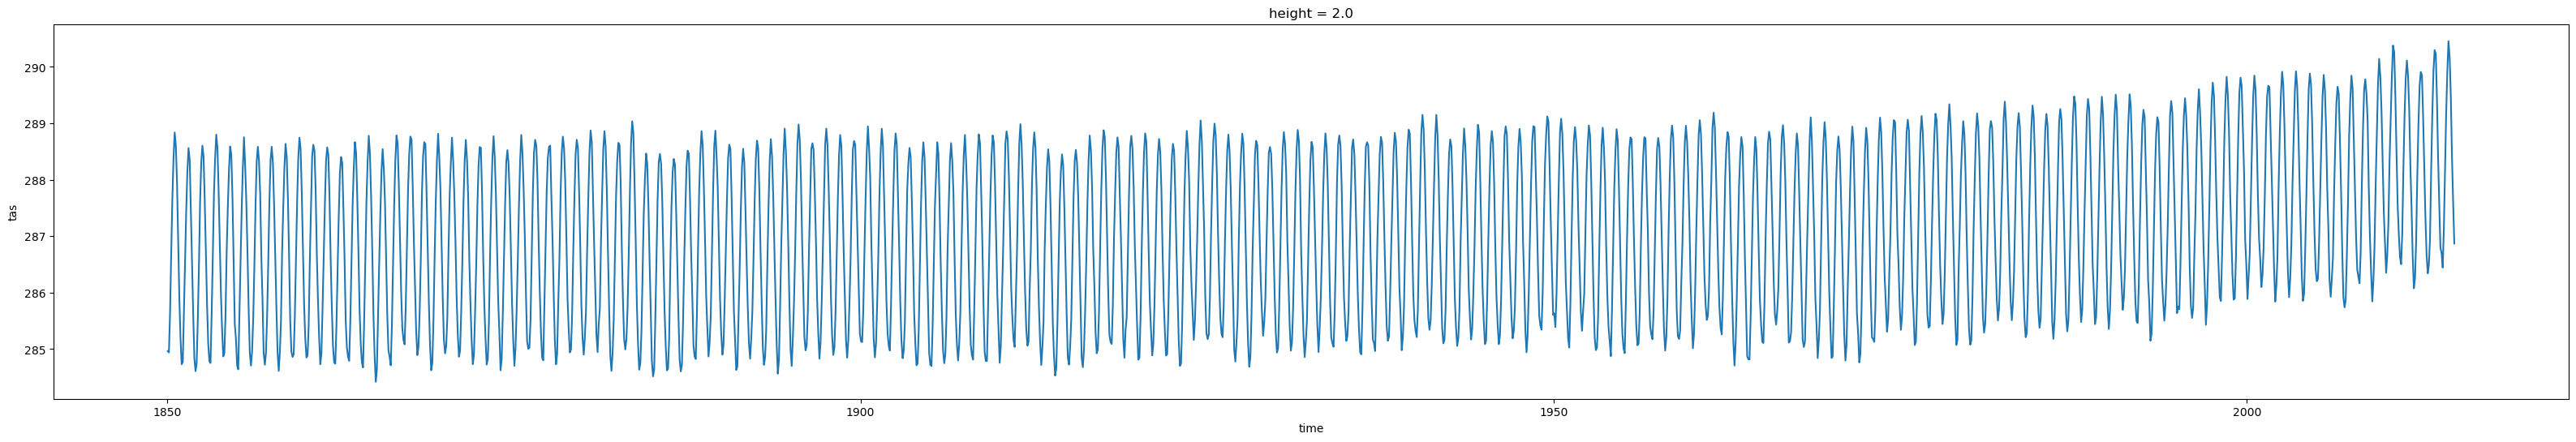

In [73]:
#plot time-series of global temperatures
fig, ax = plt.subplots(figsize = (40,6))
ds_tas_canesm5_merged.tas.plot(ax=ax)

### 1.2 Loading Multiple Models

In [47]:
#GCM picked out
gcm_list = ['NorESM2-MM',
 'ACCESS-CM2',
 'MPI-ESM1-2-HR',
 'KACE-1-0-G',
 'FGOALS-f3-L']

In [14]:
#adding in model name for coordinates instead of number
ds_list2 = list()
for source in gcm_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #concat data
    ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
    #print(source) checking if each source starts at 1850
    #print(ds_all.time[0])
    #global mean w weights
    weights = np.cos(np.deg2rad(ds_all.tas.lat))
    ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
    #slice to specific period and reassign new time index
    ds_all = ds_all.isel(time=slice(0,3000))
    ds_all = ds_all.assign(time=new_time_index)
    ds_all = ds_all.assign_coords(model=source) #creates model coordinate for the source
    #add to list
    ds_list2.append(ds_all)
ob_all2 = xr.concat(ds_list2, dim = 'model', coords = 'minimal',compat='override')
ob_all2

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


<xarray.Dataset>
Dimensions:  (time: 3000, model: 5)
Coordinates:
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
  * model    (model) <U13 'NorESM2-MM' 'ACCESS-CM2' ... 'FGOALS-f3-L'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 241), meta=np.ndarray>

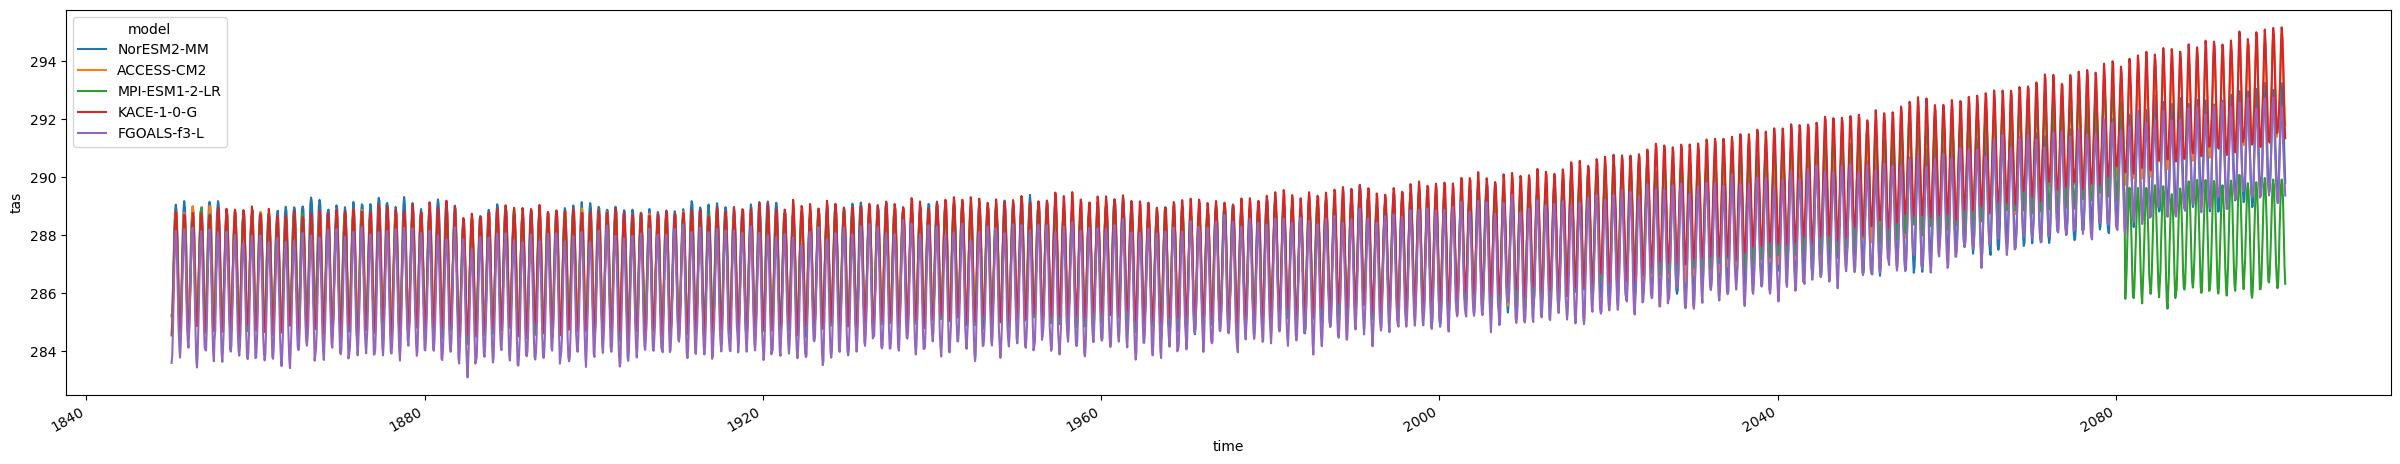

In [31]:
fig, ax = plt.subplots(figsize = (30,5))
lines = ob_all2.tas.plot.line(ax=ax,hue='model', add_legend=True) #accesses tas variable and has each model number set as a diff color
#labels = range(5) #adds labels
#plt.legend(lines, labels, ncol=2, loc='lower right') 

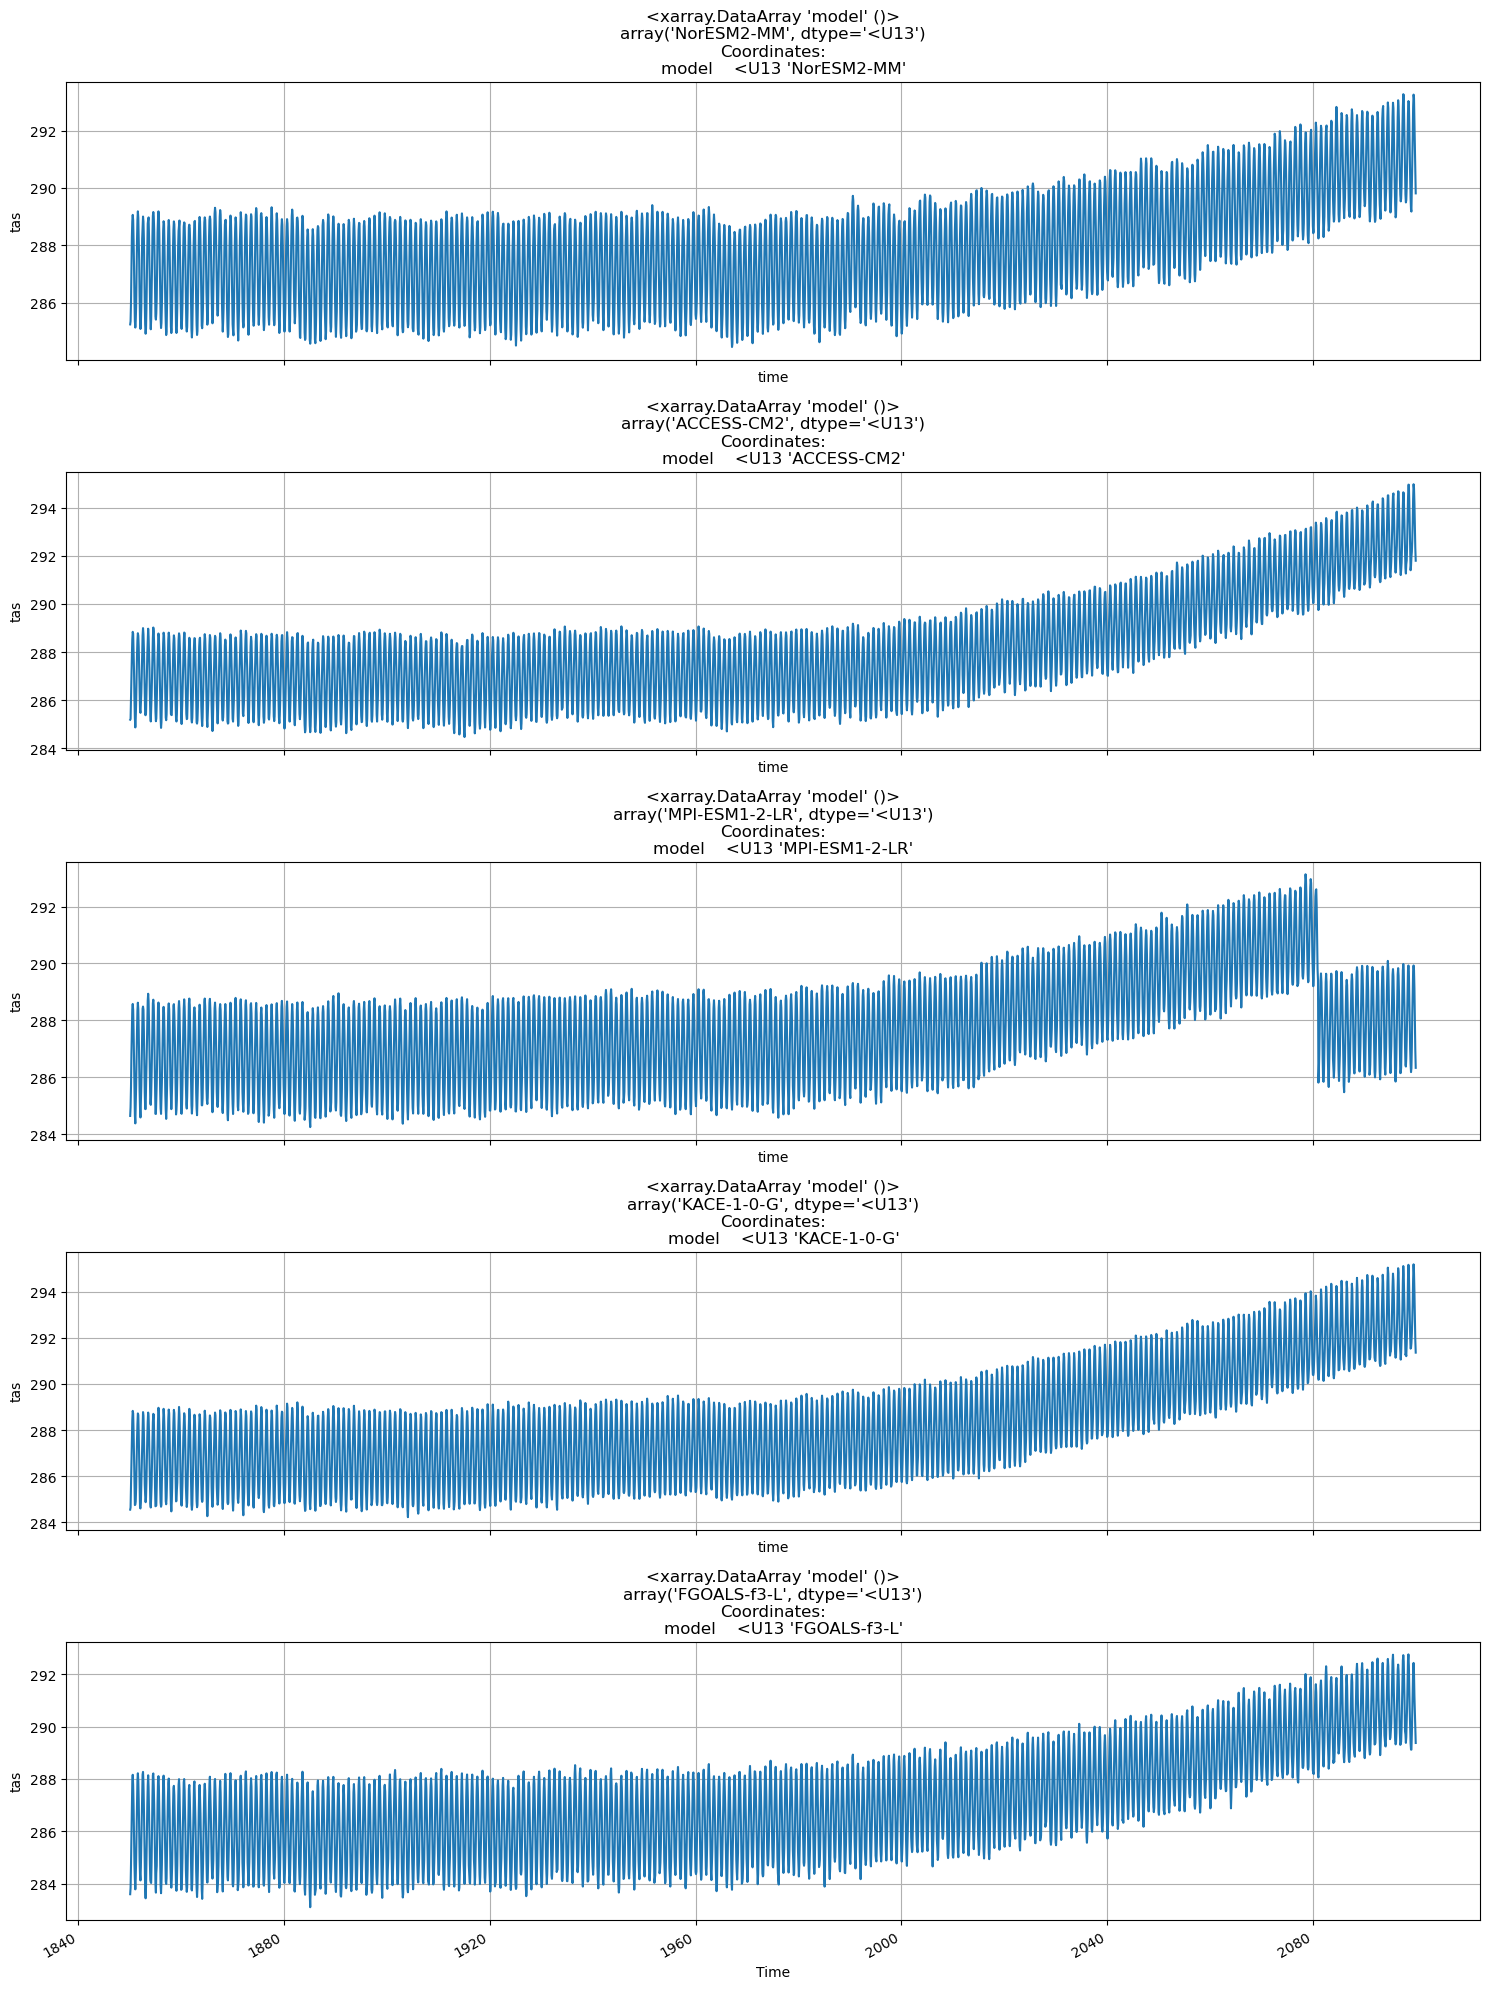

In [29]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
for i, model in enumerate(ob_all2.model): #enumerate returns iterator of pairs, each pair contains the index and the corresponding element from the iterable
    ob_all2.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
    axs[i].set_title(model) #shows what model number
    axs[i].set_ylabel('tas')
    axs[i].grid(True) #makes gridlines on plot
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

#### Trying to Fix Model 'MPI-ESM1-2-LR' 

In [82]:
temp_ob_2060 = ob_all2.tas.sel(time = slice('2060', '2099'))
temp_model_2_2060 = (temp_ob_2060.model == 'MPI-ESM1-2-LR').values
temp_model_2_2060

array([False, False,  True, False, False])

In [83]:
df_hist_tas_temp=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== 'MPI-ESM1-2-LR'")
df_ssp585_tas_temp=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== 'MPI-ESM1-2-LR'")
ds_hist_tas_temp   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas_temp =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all_temp = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all_temp.tas.lat))
ds_all_temp = ds_all_temp.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all_temp = ds_all_temp.isel(time=slice(0,3000))
ds_all_temp = ds_all_temp.assign(time=new_time_index)
ds_all_temp = ds_all_temp.sel(time=slice('2080','2099'))
model_2_temp = list(ds_all_temp.tas.values)

Text(0.5, 1.0, 'MPI-ESM1-2-LR Model from 2080 to 2100')

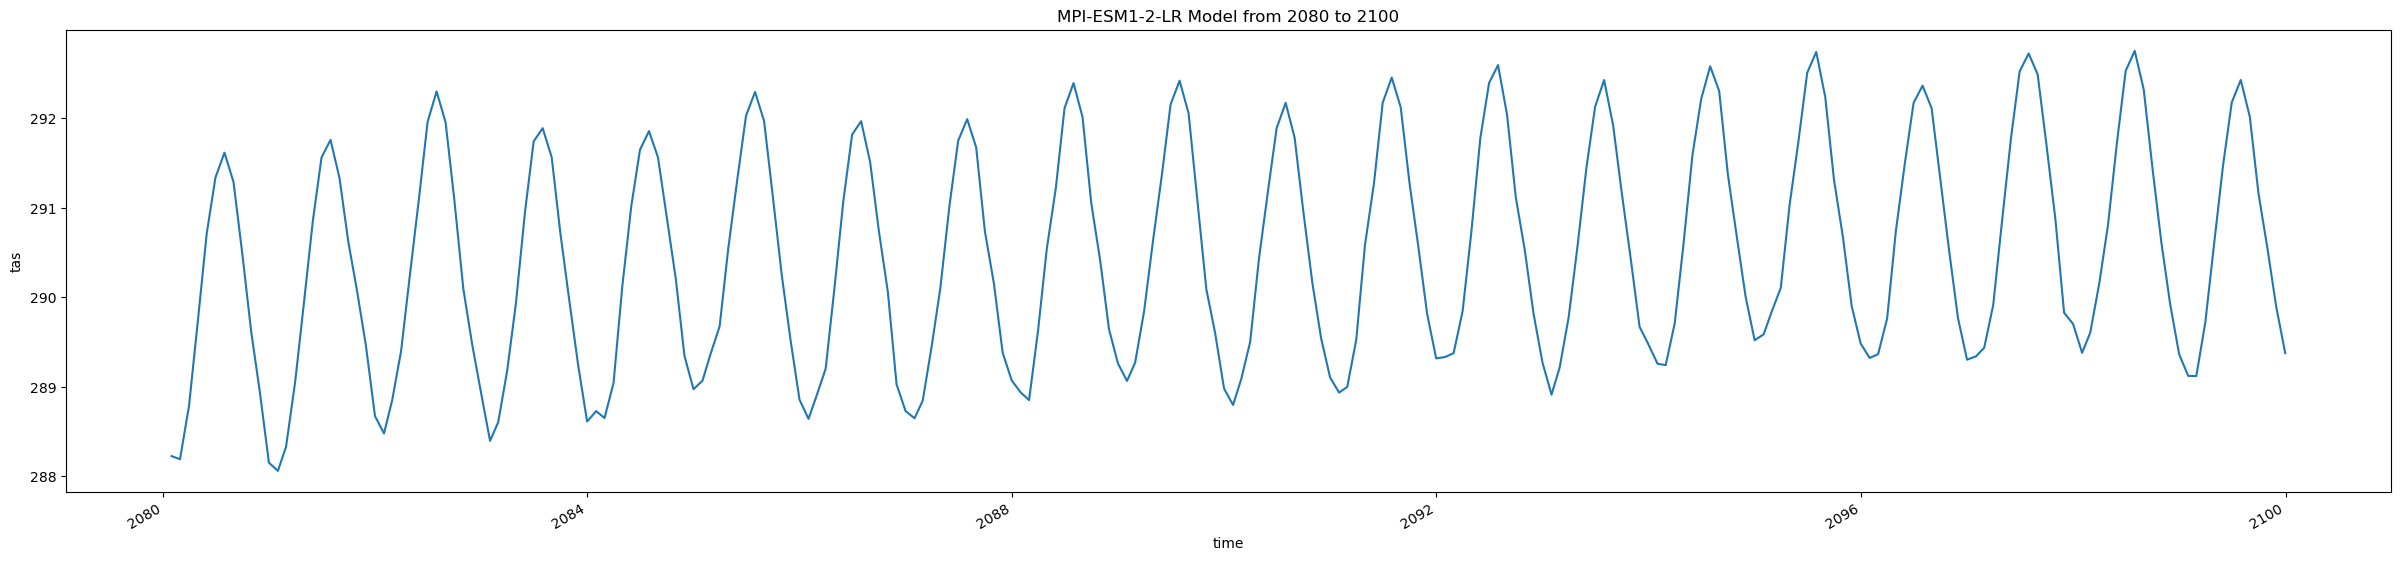

In [84]:
fig, ax = plt.subplots(figsize = (30,6))
ds_all_temp.tas.plot(ax=ax)
ax.set_title('MPI-ESM1-2-LR Model from 2080 to 2100')

In [85]:
ds_temp_temp = ob_all.tas.sel(time = slice('2080', '2099'))
tas_temp_list = np.array(ds_temp_temp.values)
tas_temp_list

array([[288.42165964, 288.47628849, 289.26362263, ..., 291.42806119,
        290.51271759, 289.80965078],
       [290.03078127, 290.19638629, 290.59828033, ..., 293.27345052,
        292.3370407 , 291.79329048],
       [289.19850862, 289.45453055, 289.97655744, ..., 288.02319916,
        286.97402242, 286.3299763 ],
       [290.3754013 , 290.48980043, 291.01829658, ..., 292.85720598,
        291.92012889, 291.3528017 ],
       [288.22285982, 288.18792999, 288.7861784 , ..., 290.54241273,
        289.89450653, 289.37419417]])

In [86]:
count = 0
for i in range(tas_temp_list.shape[0]):
    for j in range(tas_temp_list.shape[1]):
        value = tas_temp_list[i, j]
        if value < 286:
            count+=1
count

15

In [87]:
model_2_temp

[288.22285981680045,
 288.18792999063726,
 288.7861783986307,
 289.7222532269614,
 290.7149243297954,
 291.3399412555336,
 291.61728746939104,
 291.29059748469274,
 290.4968609622355,
 289.6142400369372,
 288.93368192001884,
 288.14886826955023,
 288.05806682681606,
 288.3293105726962,
 289.04636545128324,
 289.9227397574354,
 290.85100051093247,
 291.5638229374953,
 291.76046595181396,
 291.3312160923365,
 290.6236634459515,
 290.05716664285967,
 289.45357403107266,
 288.67101975497036,
 288.47626856386137,
 288.84598293118705,
 289.40155740545015,
 290.24575231739453,
 291.09546848753695,
 291.9605769044559,
 292.30241134888763,
 291.9560372614898,
 291.09129023580306,
 290.09540739165817,
 289.4812245603251,
 288.93151272677176,
 288.3935383432376,
 288.60144710370986,
 289.18011082269817,
 289.9324465690538,
 290.9461654180168,
 291.7431670500295,
 291.8911085516486,
 291.5681723268256,
 290.7159226939194,
 289.9563301129077,
 289.2451381773899,
 288.60991617175756,
 288.7257170247

In [88]:
count = 0
for i in range(len(model_2_temp)):
    if i < 286:
       count+=1
count

240

#### Expand Analysis to All Models

In [148]:
ds_list_all = list()
for source in source_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    #check member_ids
    #print("\n"+source) #checking if each source starts at 1850
    #print("Historical member_id " + str(df_hist_tas['member_id']))
    #print("\nSSP585 member_id " + str(df_ssp585_tas['member_id']))
    #load in data into dataset
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #conditional if it has missing nan values
    #if source == 'MPI-ESM1-2-HR':
        #ds_hist_tas = ds_mpi_esm_hist
    #elif source == 'AWI-CM-1-1-MR':
        #ds_hist_tas = ds_awi_cm_hist
    #check for time period of model
    #print("\n" + str(ds_all.time[0]) + "-" + str(ds_all.time[-1]))
    #concat data
    ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
    #global mean w weights
    weights = np.cos(np.deg2rad(ds_all.tas.lat))
    ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
    #slice to specific period and reassign new time index
    ds_all = ds_all.isel(time=slice(0,3000))
    ds_all = ds_all.assign(time=new_time_index)
    ds_all = ds_all.assign_coords(model=source) #creates model coordinate for the source
    ds_all.coords
    #add to list
    ds_list_all.append(ds_all)

ds_all_models = xr.concat(ds_list_all, dim = 'model', coords = 'minimal',compat='override')
ds_all_models

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\codin

<xarray.Dataset>
Dimensions:  (time: 3000, model: 32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
  * model    (model) <U16 'CESM2-WACCM' 'CanESM5' ... 'ACCESS-ESM1-5' 'MIROC6'
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 126), meta=np.ndarray>

In [149]:
#drop height coordinate
ds_all_models = ds_all_models.drop_vars('height')
ds_all_models

<xarray.Dataset>
Dimensions:  (time: 3000, model: 32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
  * model    (model) <U16 'CESM2-WACCM' 'CanESM5' ... 'ACCESS-ESM1-5' 'MIROC6'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 126), meta=np.ndarray>

#### Adding 12 More Models

In [150]:
#had to scrap the for loop idea because i should make sure each model is consistent w variables and that they dont have any individ problems
r1i1p1f2_member_list = ['MCM-UA-1-0', 'MIROC-ES2L', 'GISS-E2-1-H', 'CNRM-CM6-1-HR', 'UKESM1-0-LL']

In [151]:
#make a separate list to concat with ds_all_models 
ds_12_models_list = list()
#query to individual model
df_hist_tas = df.query(  "source_id == 'CNRM-ESM2-1' & member_id == 'r2i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CNRM-ESM2-1' & member_id == 'r2i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#remove height coord
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list w other ensemble of models
ds_12_models_list.append(ds_all)
#concat to ds_all_models

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U11 'CNRM-ESM2-1'


In [152]:
#make a separate list to concat with ds_all_models 
#query to individual model
df_hist_tas = df.query(  "source_id == 'GISS-E2-1-G' & member_id == 'r2i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'GISS-E2-1-G' & member_id == 'r2i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#remove height coord
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list w other ensemble of models
ds_12_models_list.append(ds_all)
#concat to ds_all_models

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U11 'GISS-E2-1-G'


In [153]:
#make a separate list to concat with ds_all_models 
#query to individual model
df_hist_tas = df.query(  "source_id == 'CanESM5-CanOE' & member_id == 'r1i1p2f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CanESM5-CanOE' & member_id == 'r1i1p2f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#remove height coord
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list w other ensemble of models
ds_12_models_list.append(ds_all)
#concat to ds_all_models

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U13 'CanESM5-CanOE'


In [154]:
df_hist_tas = df.query(  "source_id == 'MCM-UA-1-0'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'MCM-UA-1-0' & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#rename latitude and longitude to lat/lon for consistency
ds_all = ds_all.rename({'latitude': 'lat', 'longitude': 'lon'})
#print(ds_all.tas)
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#remove height coord
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list
ds_12_models_list.append(ds_all)

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U10 'MCM-UA-1-0'


In [155]:
df_hist_tas = df.query(  "source_id == 'MIROC-ES2L'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'MIROC-ES2L'  & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#remove height coord
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list
ds_12_models_list.append(ds_all)

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U10 'MIROC-ES2L'


In [156]:
df_hist_tas = df.query(  "source_id == 'GISS-E2-1-H'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'GISS-E2-1-H'  & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#remove height coord
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list
ds_12_models_list.append(ds_all)

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U11 'GISS-E2-1-H'


In [157]:
df_hist_tas = df.query(  "source_id == 'CNRM-CM6-1-HR'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CNRM-CM6-1-HR'  & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#remove height coord
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list
ds_12_models_list.append(ds_all)

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U13 'CNRM-CM6-1-HR'


In [158]:
df_hist_tas = df.query(  "source_id == 'UKESM1-0-LL'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'UKESM1-0-LL'  & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#remove height coord
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list
ds_12_models_list.append(ds_all)

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U11 'UKESM1-0-LL'


In [159]:
df_hist_tas = df.query(  "source_id == 'HadGEM3-GC31-LL'  & member_id == 'r1i1p1f3' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'HadGEM3-GC31-LL'  & member_id == 'r1i1p1f3' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#remove height coord
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list
ds_12_models_list.append(ds_all)

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U15 'HadGEM3-GC31-LL'


In [160]:
df_hist_tas = df.query(  "source_id == 'CESM2'  & member_id == 'r4i1p1f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CESM2'  & member_id == 'r4i1p1f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#check all dimensions for consistency
print(ds_all.coords)
#assign height missing dimension (height was also in the 34 ensemble so we should keep i consistent)
ds_all = ds_all.assign_coords(height = 2.0)
#add to list
ds_12_models_list.append(ds_all)

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U5 'CESM2'


In [161]:
df_hist_tas = df.query(  "source_id == 'HadGEM3-GC31-MM'  & member_id == 'r1i1p1f3' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'HadGEM3-GC31-MM'  & member_id == 'r1i1p1f3' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#drop height coordinate for consistency
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list
ds_12_models_list.append(ds_all)

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U15 'HadGEM3-GC31-MM'


In [162]:
df_hist_tas = df.query(  "source_id == 'CNRM-ESM2-1'  & member_id == 'r2i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CNRM-ESM2-1'  & member_id == 'r2i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all.tas.lat))
ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all = ds_all.isel(time=slice(0,3000))
ds_all = ds_all.assign(time=new_time_index)
ds_all = ds_all.assign_coords(model=ds_hist_tas.source_id) #creates model coordinate for the source
#drop height coordinate for consistency
ds_all = ds_all.drop_vars('height')
#check all dimensions for consistency
print(ds_all.coords)
#add to list
ds_12_models_list.append(ds_all)

Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
    model    <U11 'CNRM-ESM2-1'


In [163]:
#rerun models to include new 12 models
#do we concat all ds_12_models_list together first and then concat w the big dataset?
#check ds_models time periods and such to make sure that we have all the correct data in
ds_12_models = xr.concat(ds_12_models_list, dim = 'model', coords = 'minimal',compat='override')
ds_12_models = ds_12_models.drop_vars('height') #dropping height bc of incompatibility, not that important
ds_12_models

<xarray.Dataset>
Dimensions:    (time: 3000, model: 12)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
  * model      (model) <U15 'CNRM-ESM2-1' 'GISS-E2-1-G' ... 'CNRM-ESM2-1'
Data variables:
    tas        (model, time) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>
    areacella  (model, time) float64 dask.array<chunksize=(12, 1980), meta=np.ndarray>

In [168]:
#concat to big dataset for all ensemble of models
#44 because I dropped the 2 models that i was having trouble dealing nan with
ds_all_44 = xr.concat([ds_12_models, ds_all_models], dim = 'model', coords = 'minimal', compat = 'override')
ds_all_44 = ds_all_44.drop_vars('areacella') #remove grid-cell information bc it's not needed
ds_all_44

<xarray.Dataset>
Dimensions:  (time: 3000, model: 44)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
  * model    (model) <U16 'CNRM-ESM2-1' 'GISS-E2-1-G' ... 'MIROC6'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>

#### Plots for Multiple Models

In [171]:
#general fn for makes these subplots
def plot_time_series5(fig_counter_input, num_subplots, model_index, dataset):
    fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 20), sharex=True)
    fig_counter = fig_counter_input
    while fig_counter < (fig_counter_input + num_subplots): #made another while loop to separate the graphs and make it cleaner
        for i, model in enumerate(dataset.model[model_index:]): #sliced from 30th index after last model figure shown in previous cell block (index should be same each time in dataset)
            if fig_counter >= (fig_counter_input + num_subplots):
                break
            dataset.sel(model=model).tas.plot(ax=axs[i],label=model)
            axs[i].set_title(model) #shows what model number
            axs[i].set_ylabel('tas')
            axs[i].grid(True) #makes gridlines on plot
            fig_counter +=1
    axs[-1].set_xlabel('Time') 
    plt.tight_layout() #creates a better layout for subplots
    plt.show()

ValueError: different number of dimensions on data and dims: 1 vs 0

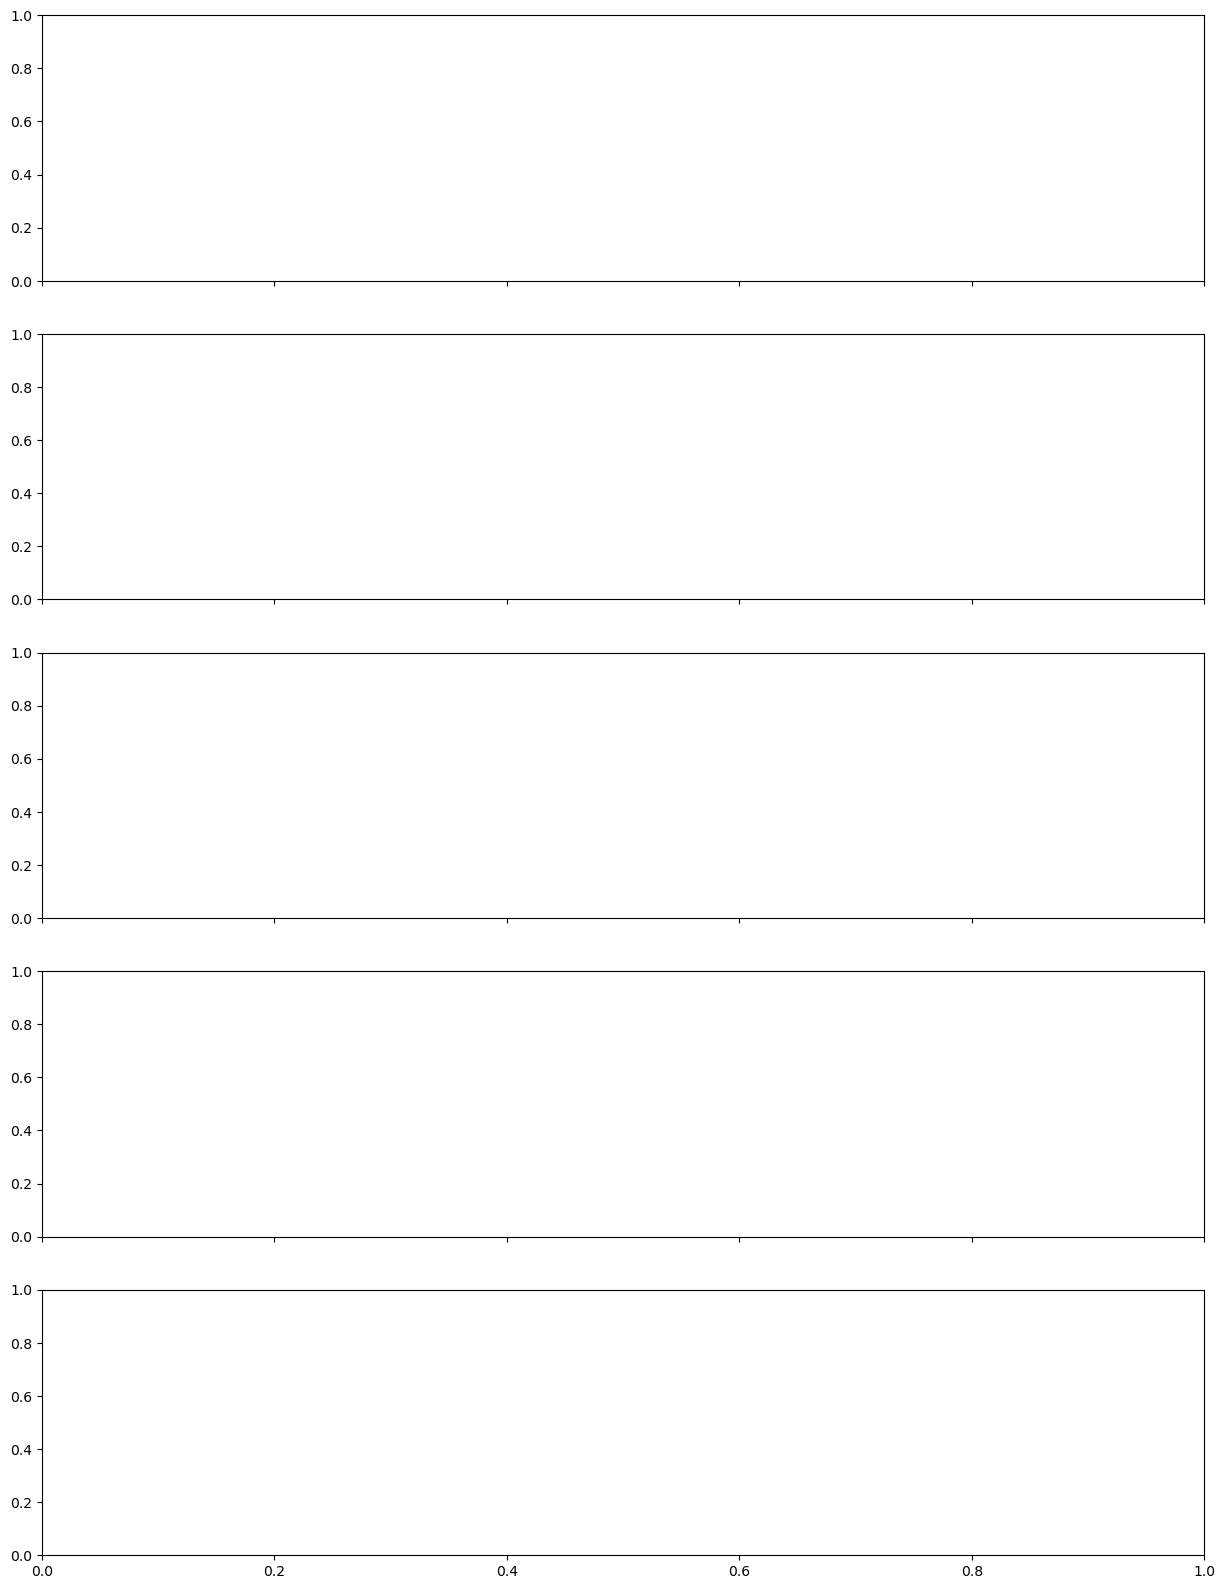

In [172]:
plot_time_series5(0,5,0,ds_all_44)

ValueError: different number of dimensions on data and dims: 1 vs 0

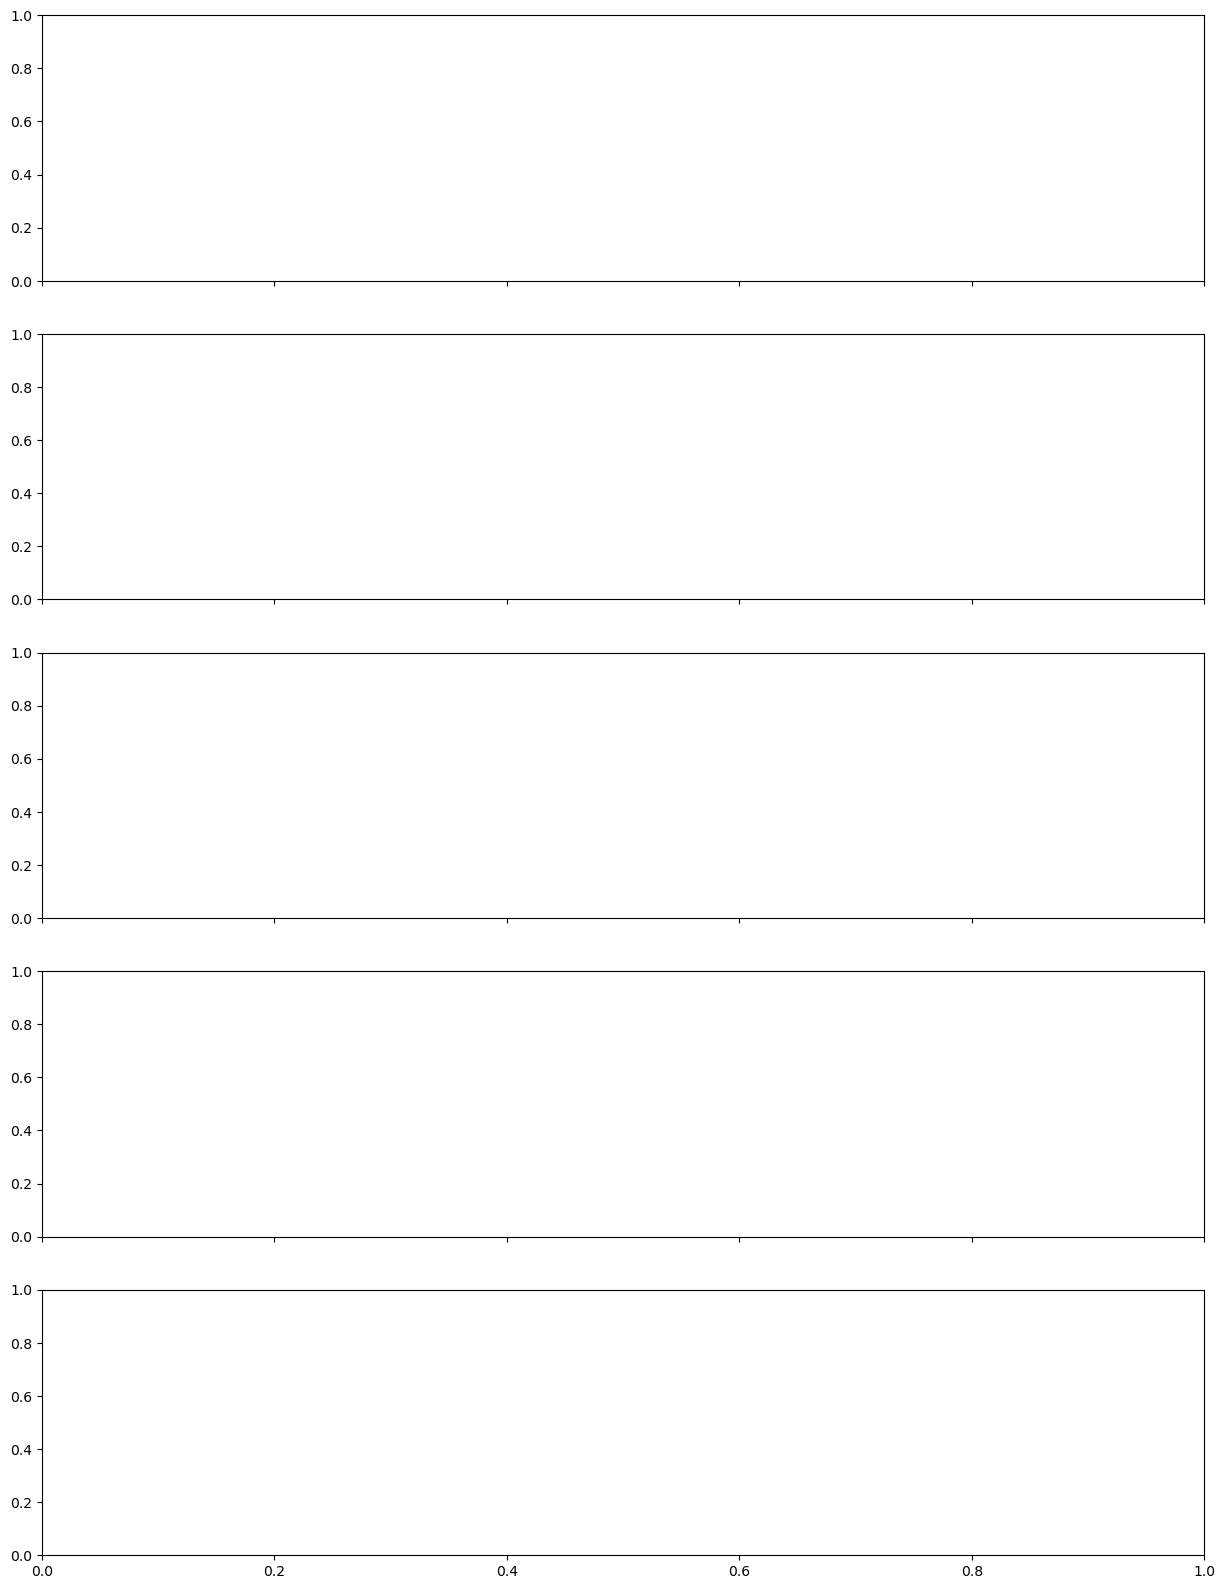

In [173]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter = 0
while fig_counter < 5:
    for i, model in enumerate(ds_all_44.model): #enumerate returns iterator of pairs, each pair contains the index and the corresponding element from the iterable
        if fig_counter >= 5:
            break
        ds_all_44.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

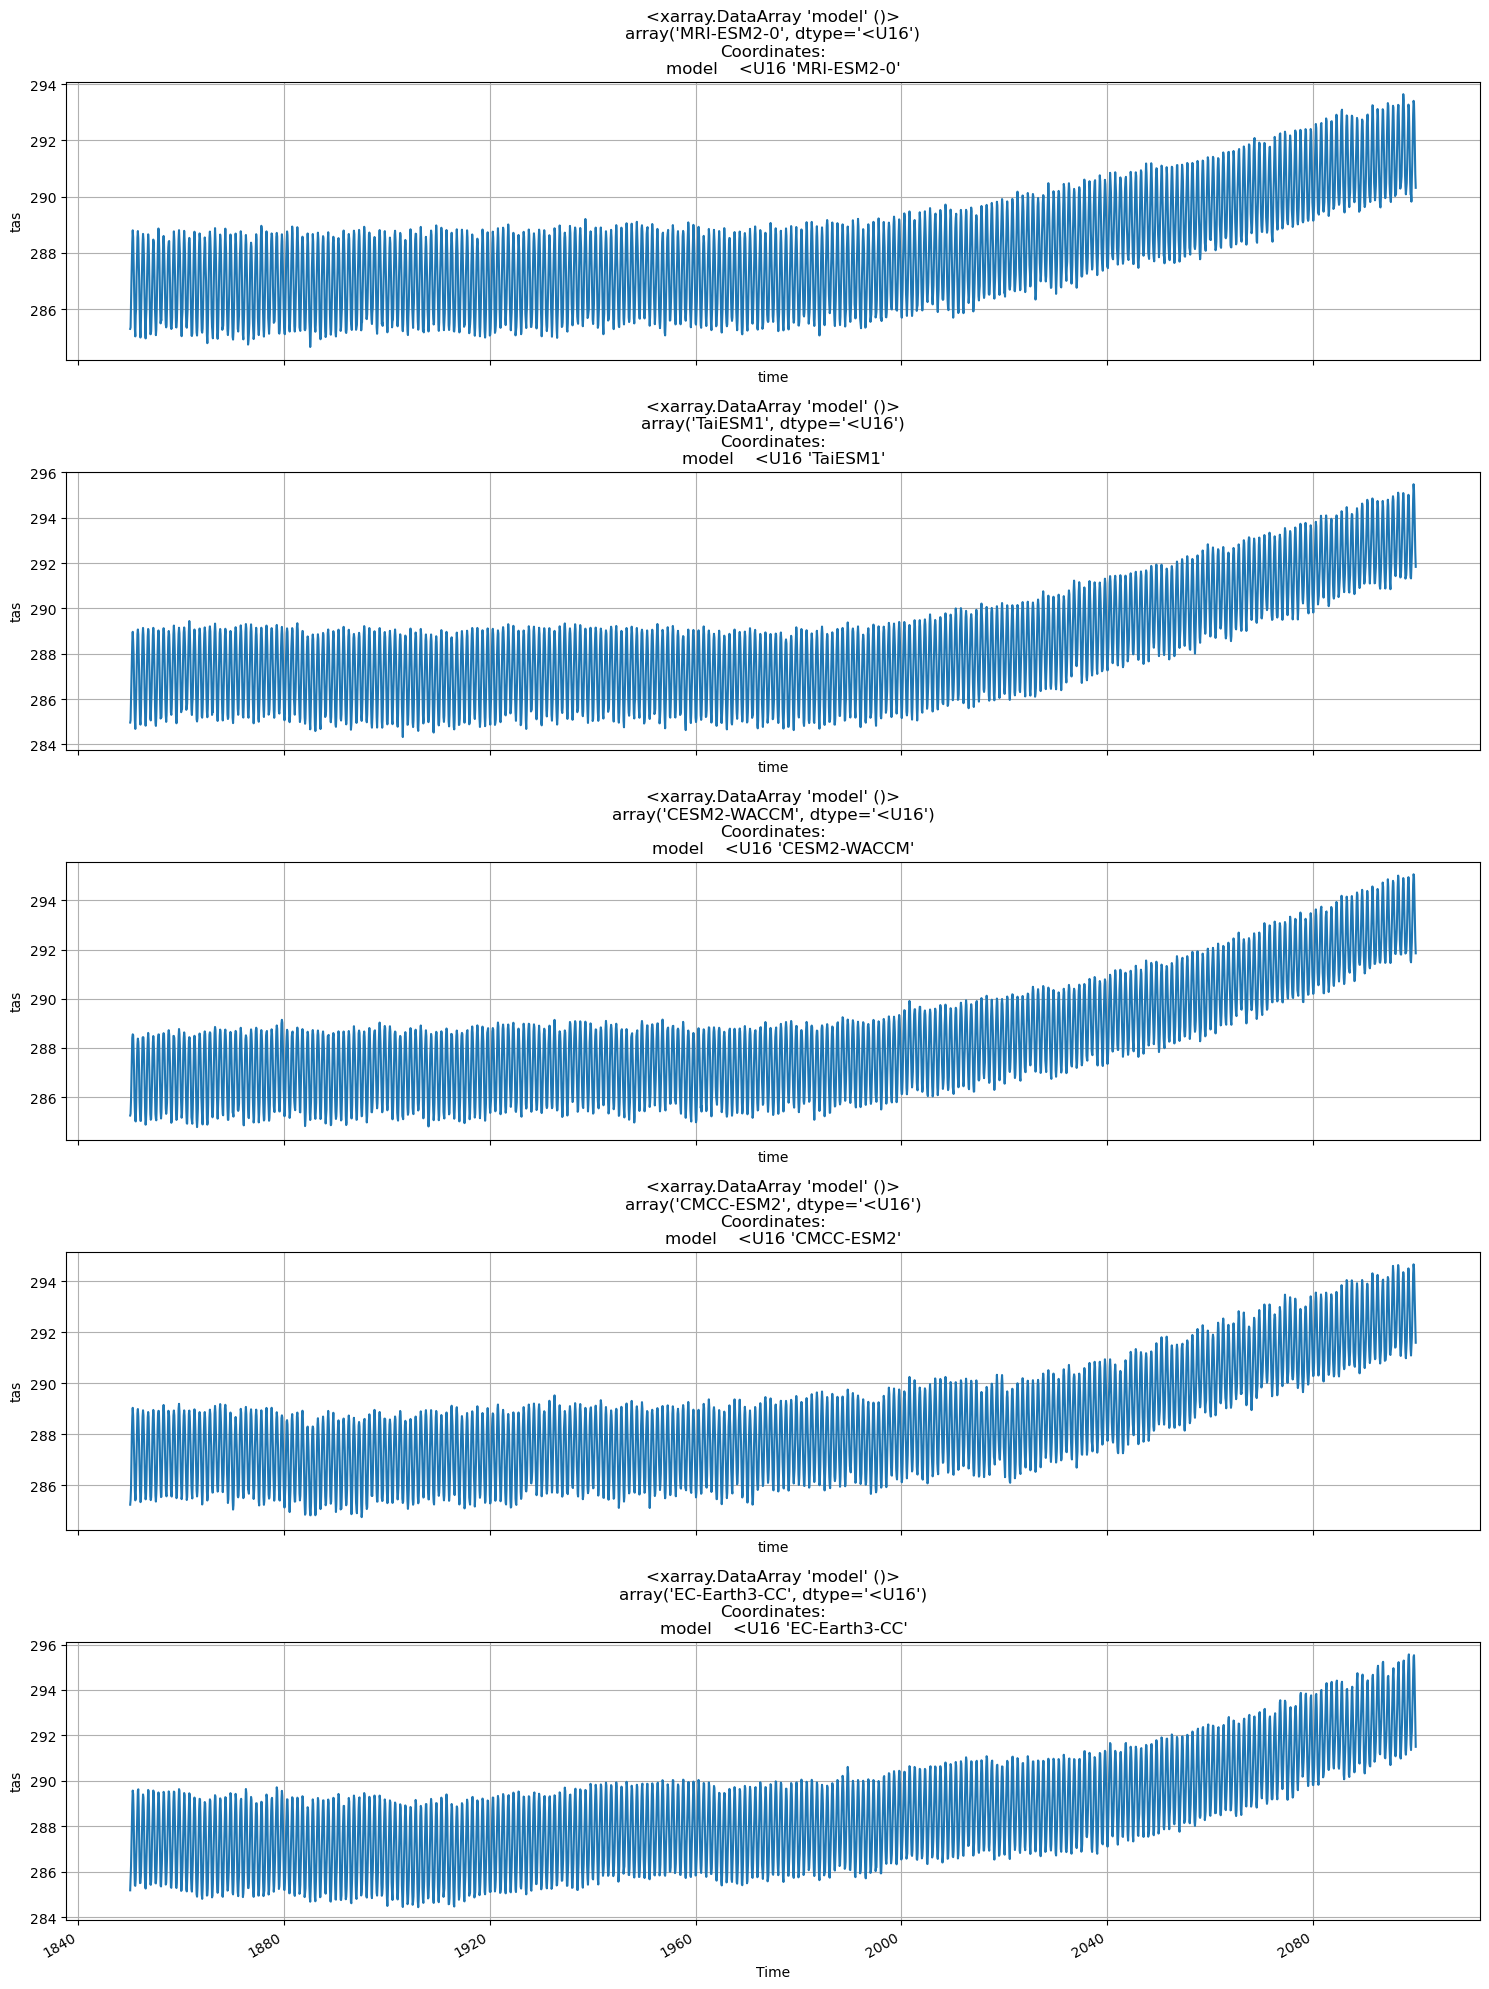

In [18]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_2 = 5
while fig_counter_2 < 10: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[5:]): #sliced from 5th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_2 >= 10:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_2 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

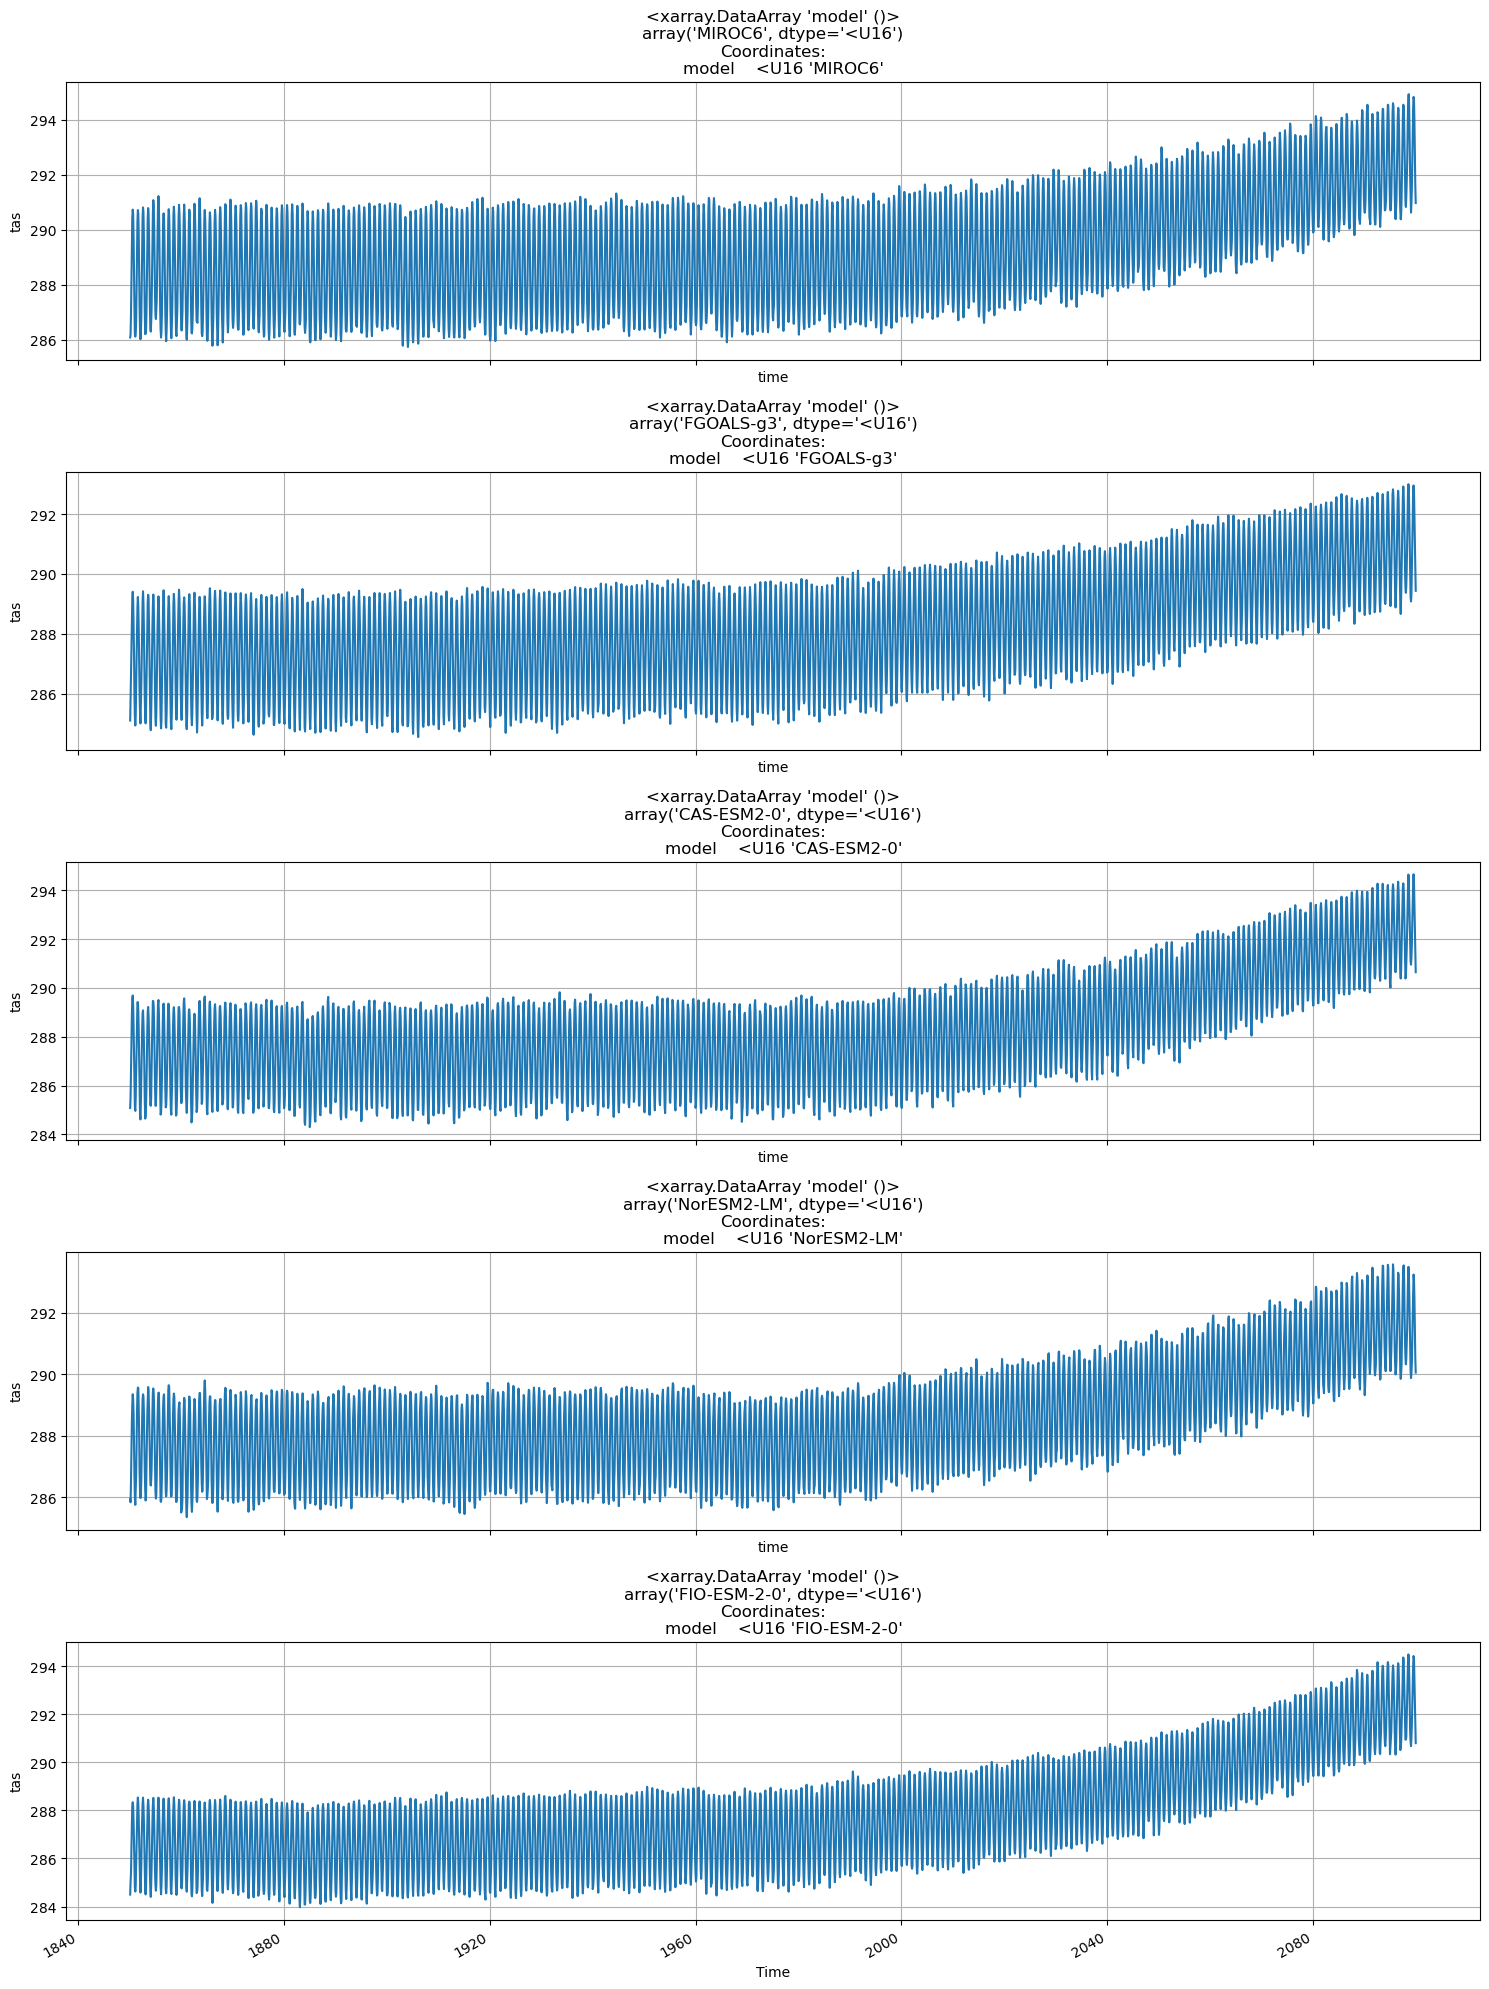

In [19]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_3 = 10
while fig_counter_3 < 15: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[10:]): #sliced from 10th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_3 >= 15:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_3 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

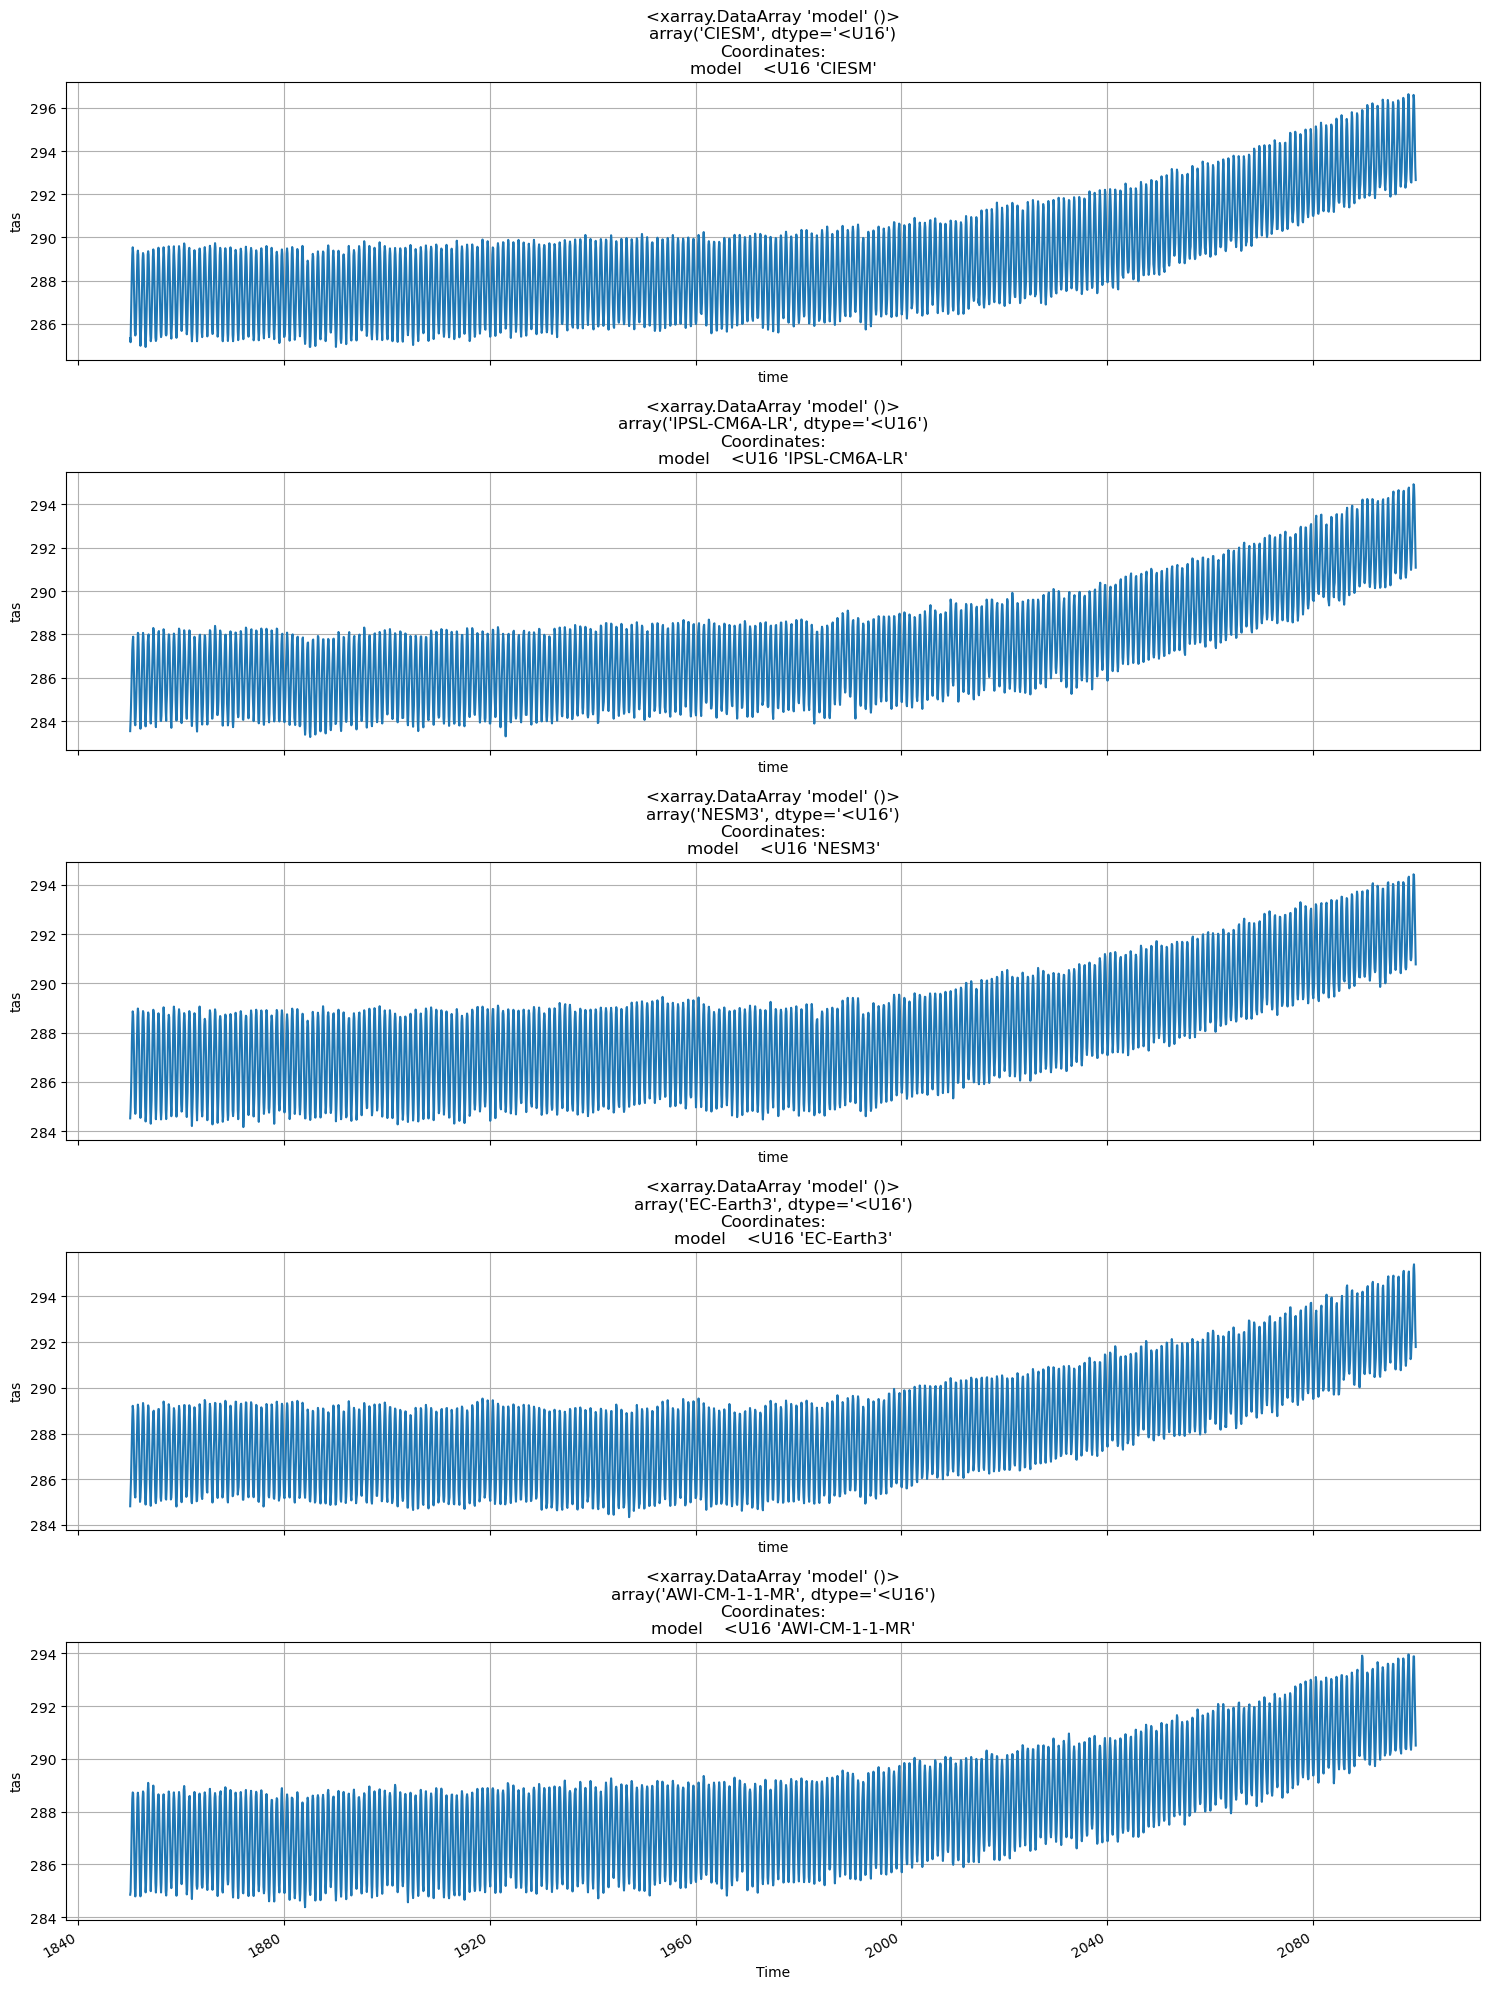

In [20]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_4 = 15
while fig_counter_4 < 20: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[15:]): #sliced from 15th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_4 >= 20:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_4 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

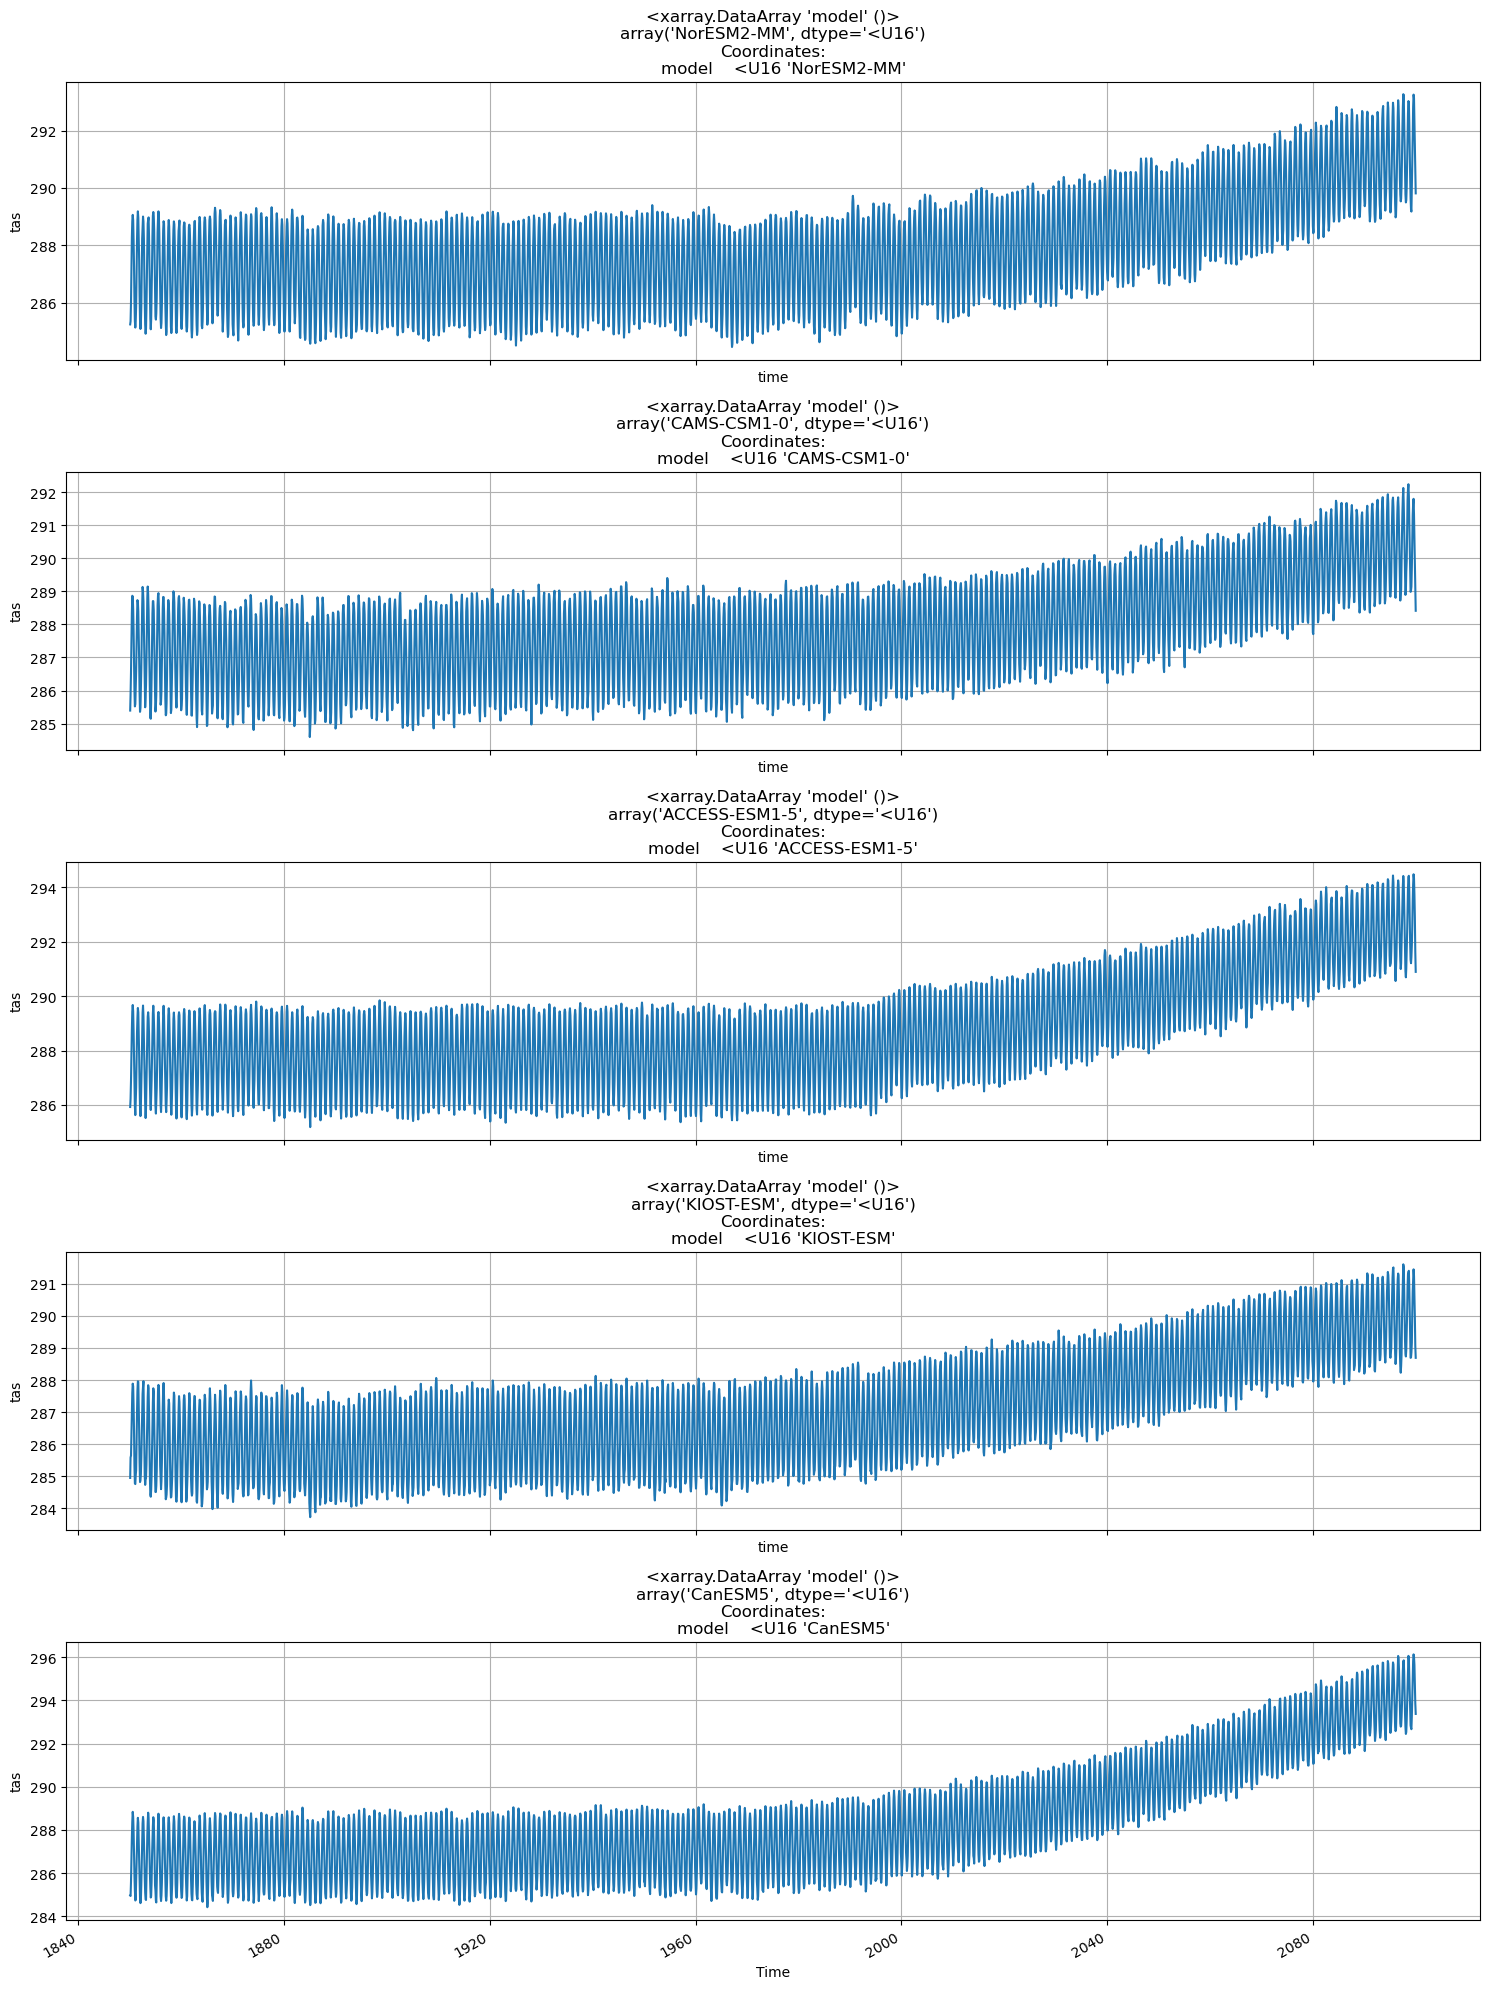

In [21]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_5 = 20
while fig_counter_5 < 25: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[20:]): #sliced from 20th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_5 >= 25:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_5 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

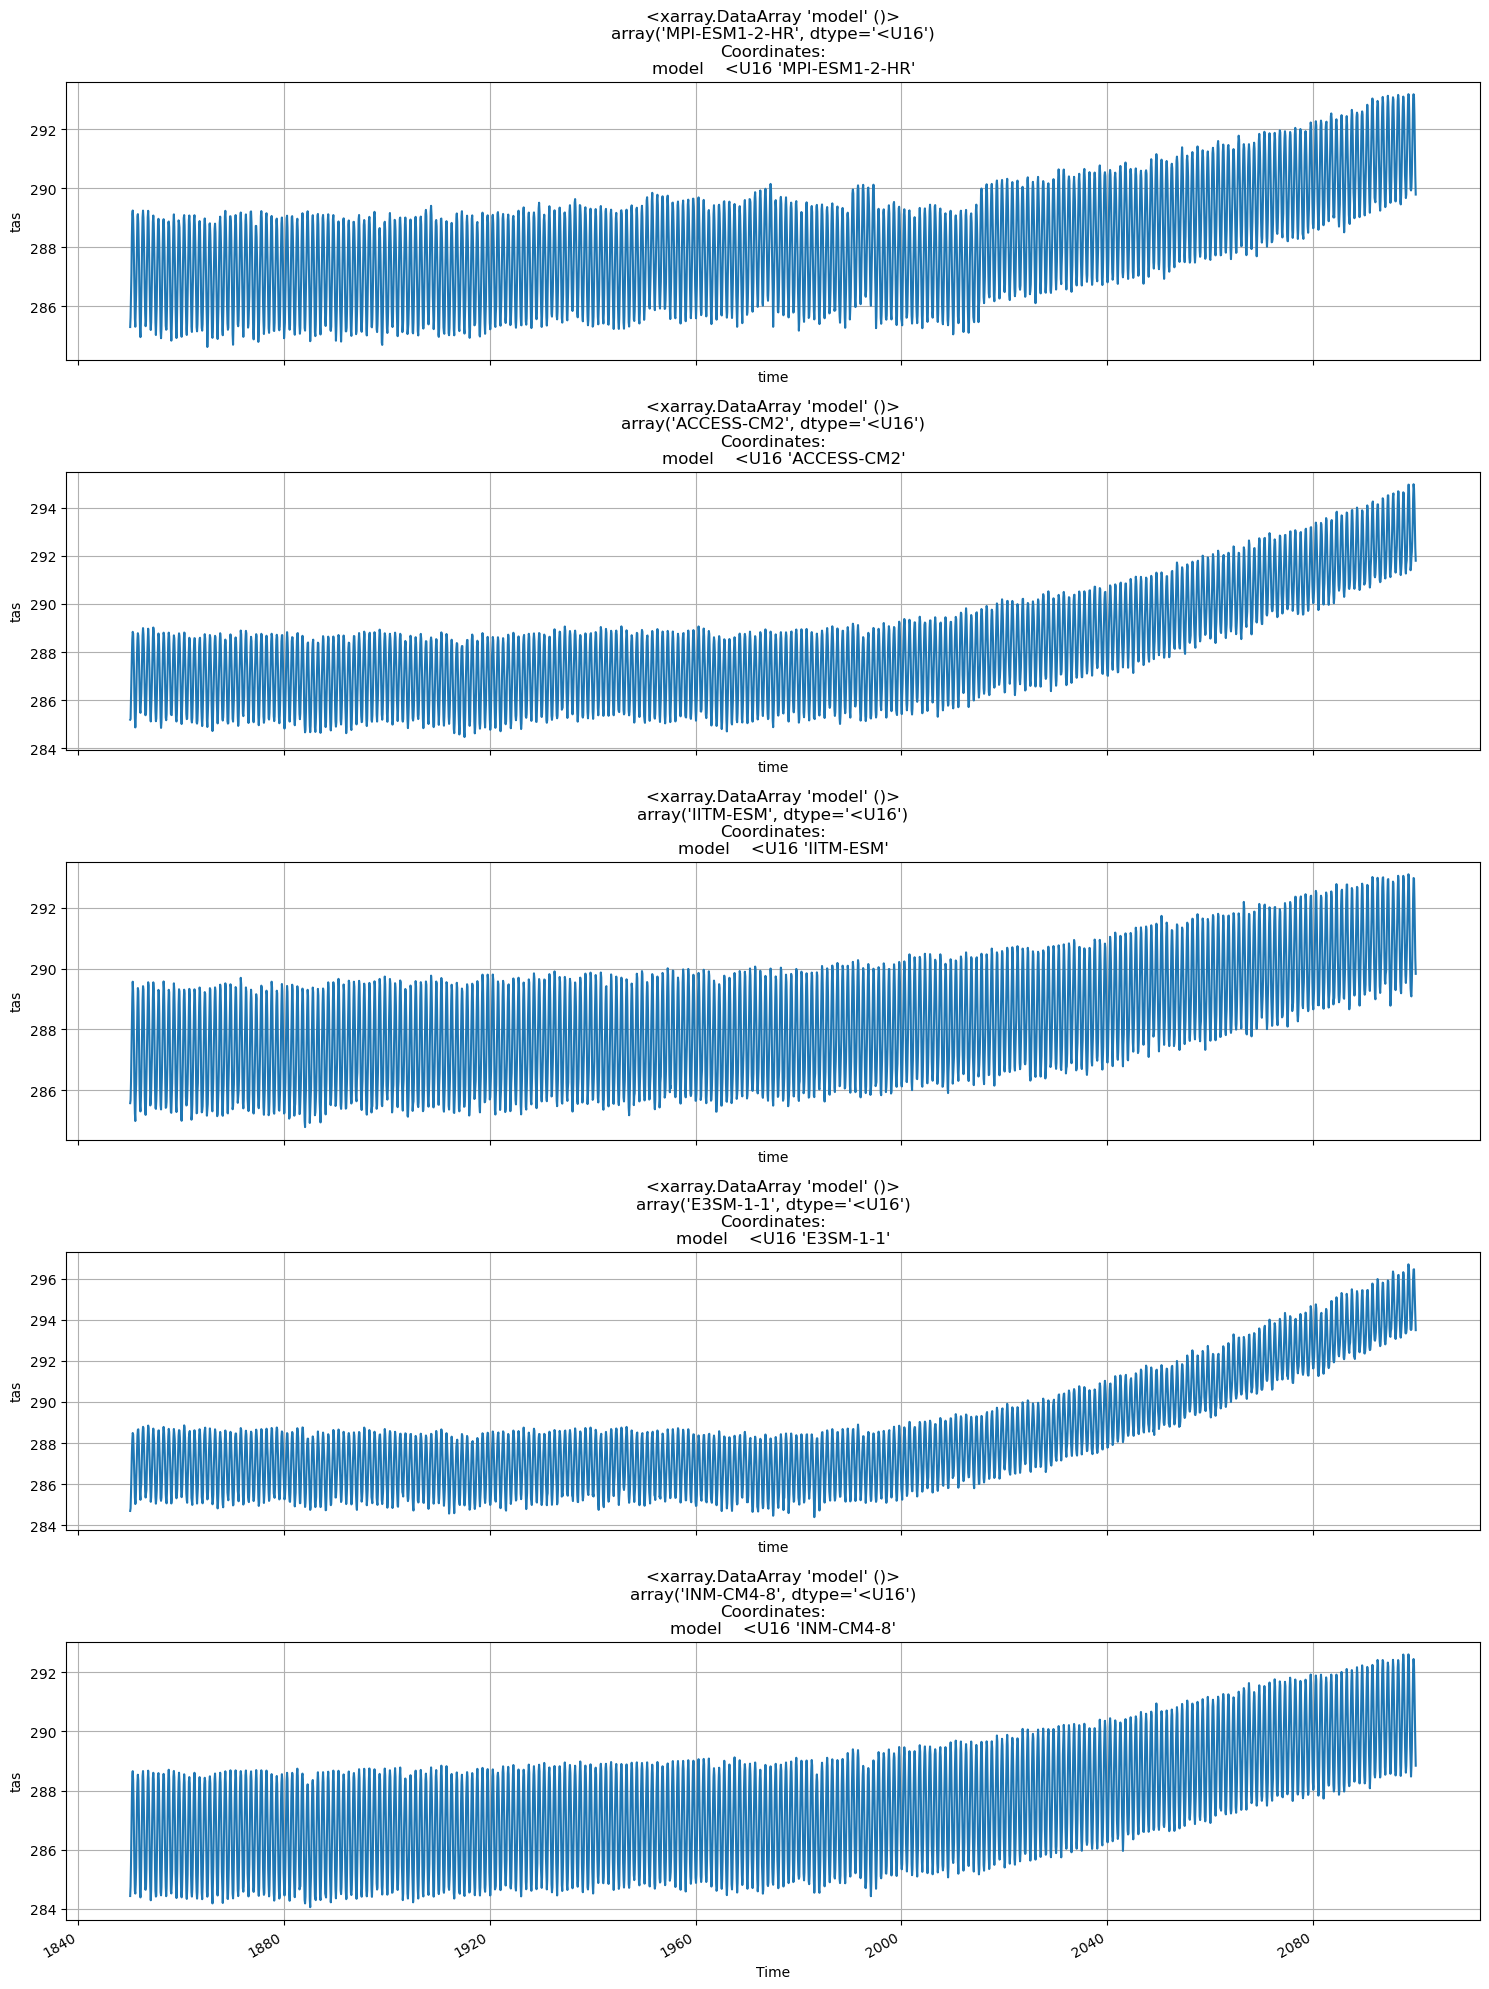

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_6 = 25
while fig_counter_6 < 30: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[25:]): #sliced from 25th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_6 >= 30:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_6 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

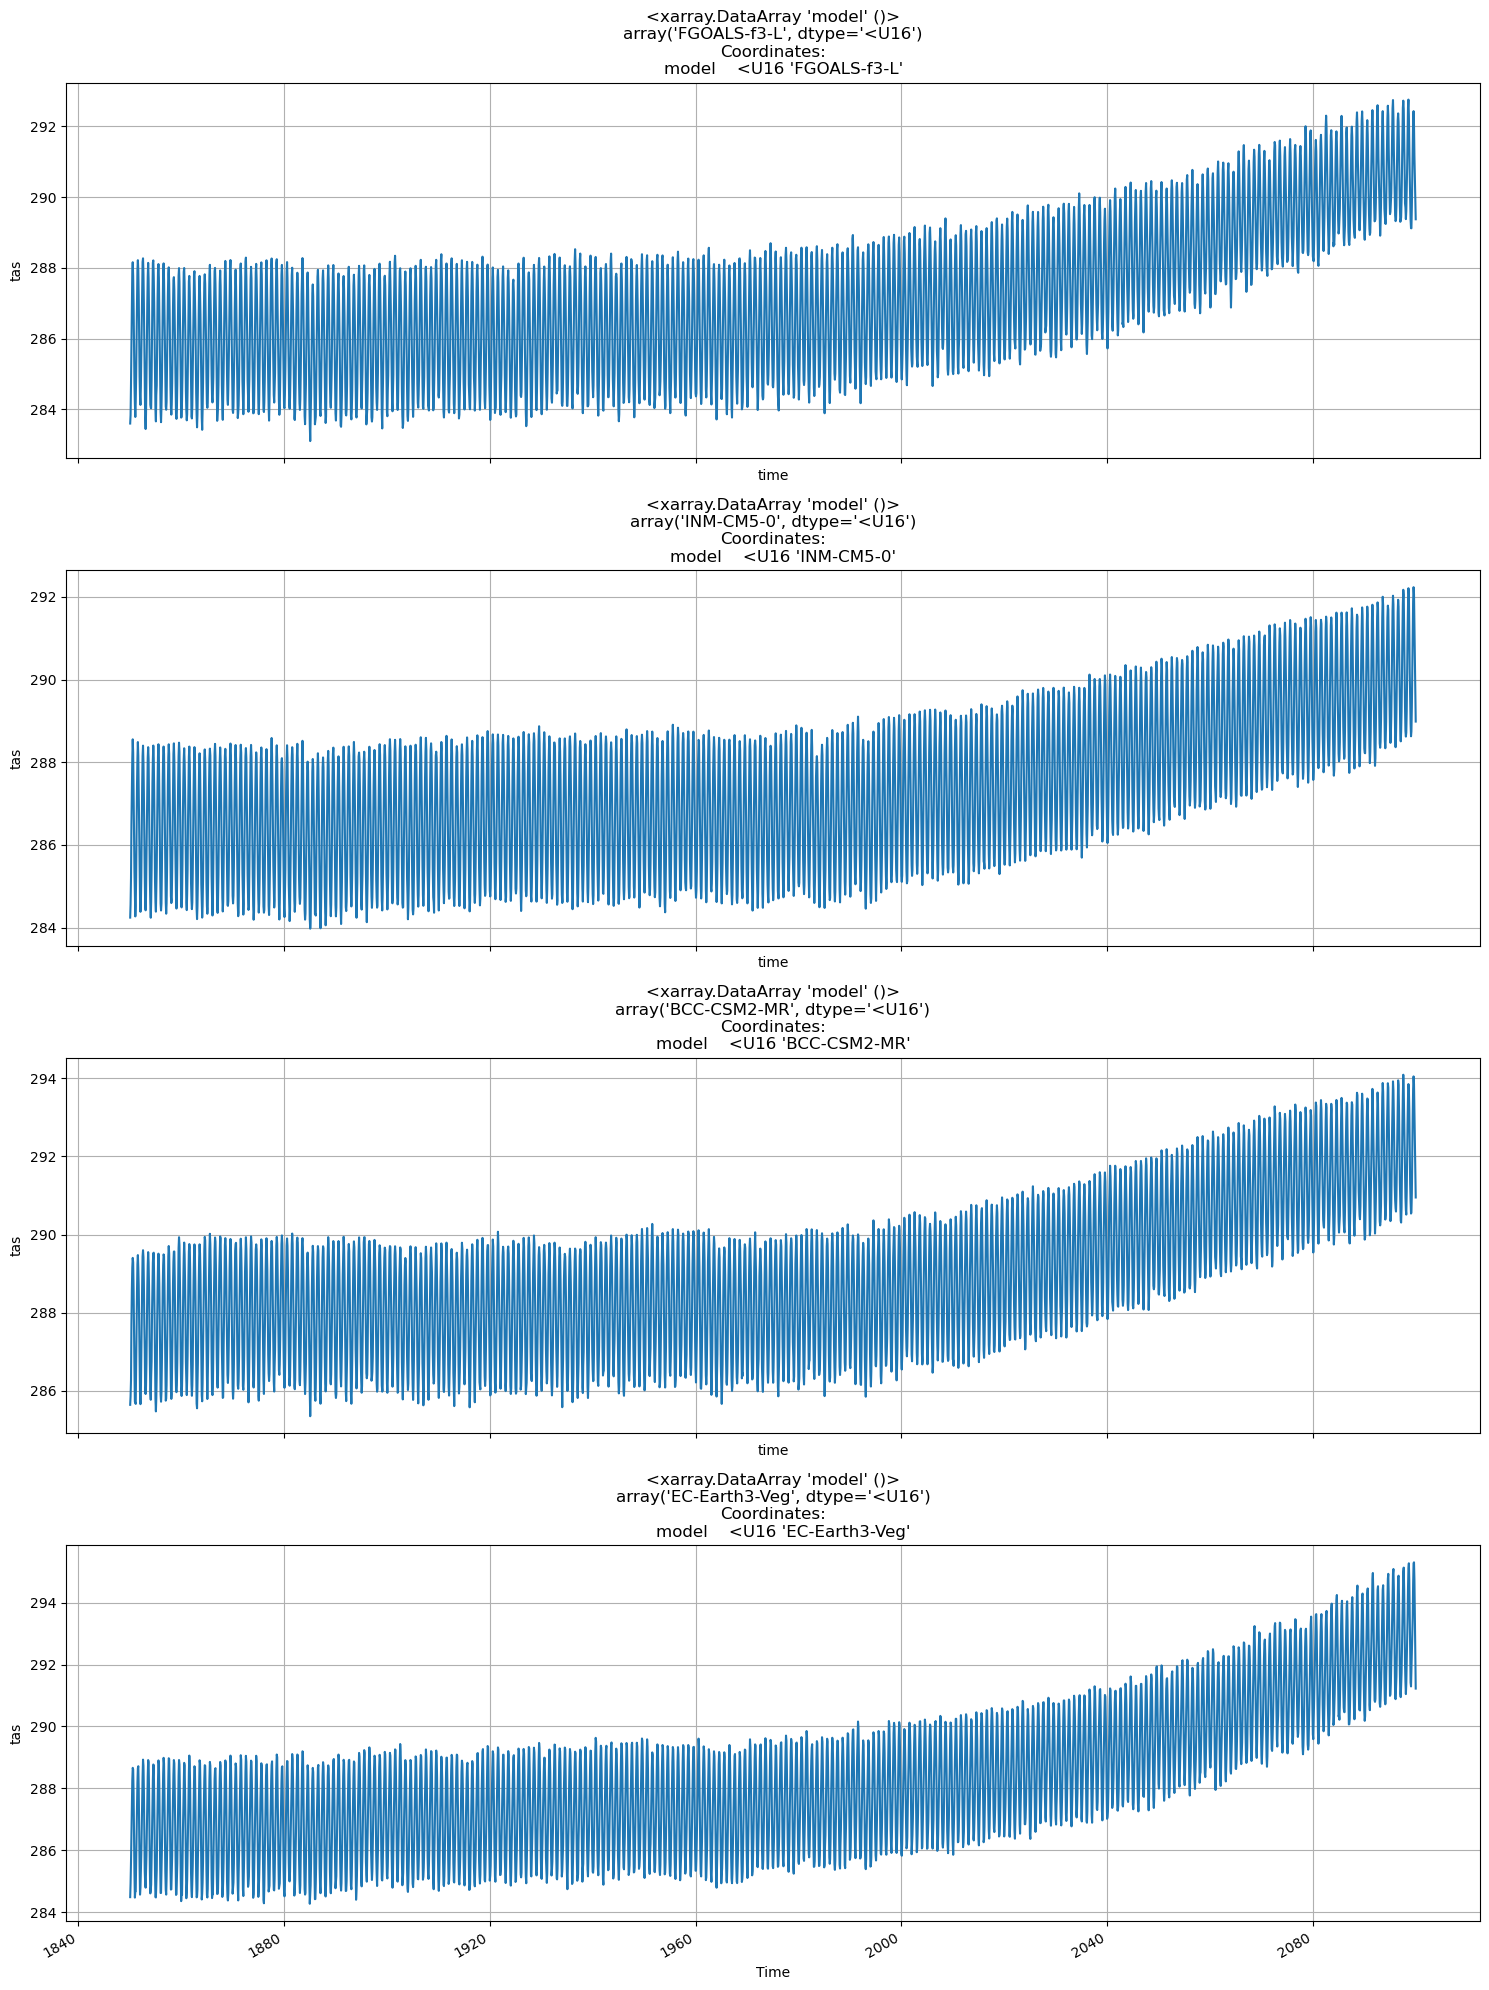

In [26]:
fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=True)
fig_counter_7 = 30
while fig_counter_7 < 34: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[30:]): #sliced from 30th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_7 >= 34:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_7 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

### 1.3 Compute Monthly Anomalies

In [70]:
#remove seasonal cycle
ds_all_models_anom = ds_all_models - ds_all_models.tas.groupby('time.month').mean('time')
#remove baseline: remove avg temp from 1850 to 1900
#ensure that what we are plotting are monthly anomalies relative to an 1850-1900 baseline
ds_all_models_anom = ds_all_models.tas.groupby('time.month') - ds_all_models.tas.groupby('time.month').mean('time')
ds_all_models_anom

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\dask\array\core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 250 times more chunks
  return self.array[key]


<xarray.DataArray 'tas' (model: 34, time: 3000)>
dask.array<sub, shape=(34, 3000), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
  * model    (model) <U16 'AWI-CM-1-1-MR' 'ACCESS-ESM1-5' ... 'E3SM-1-1'
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

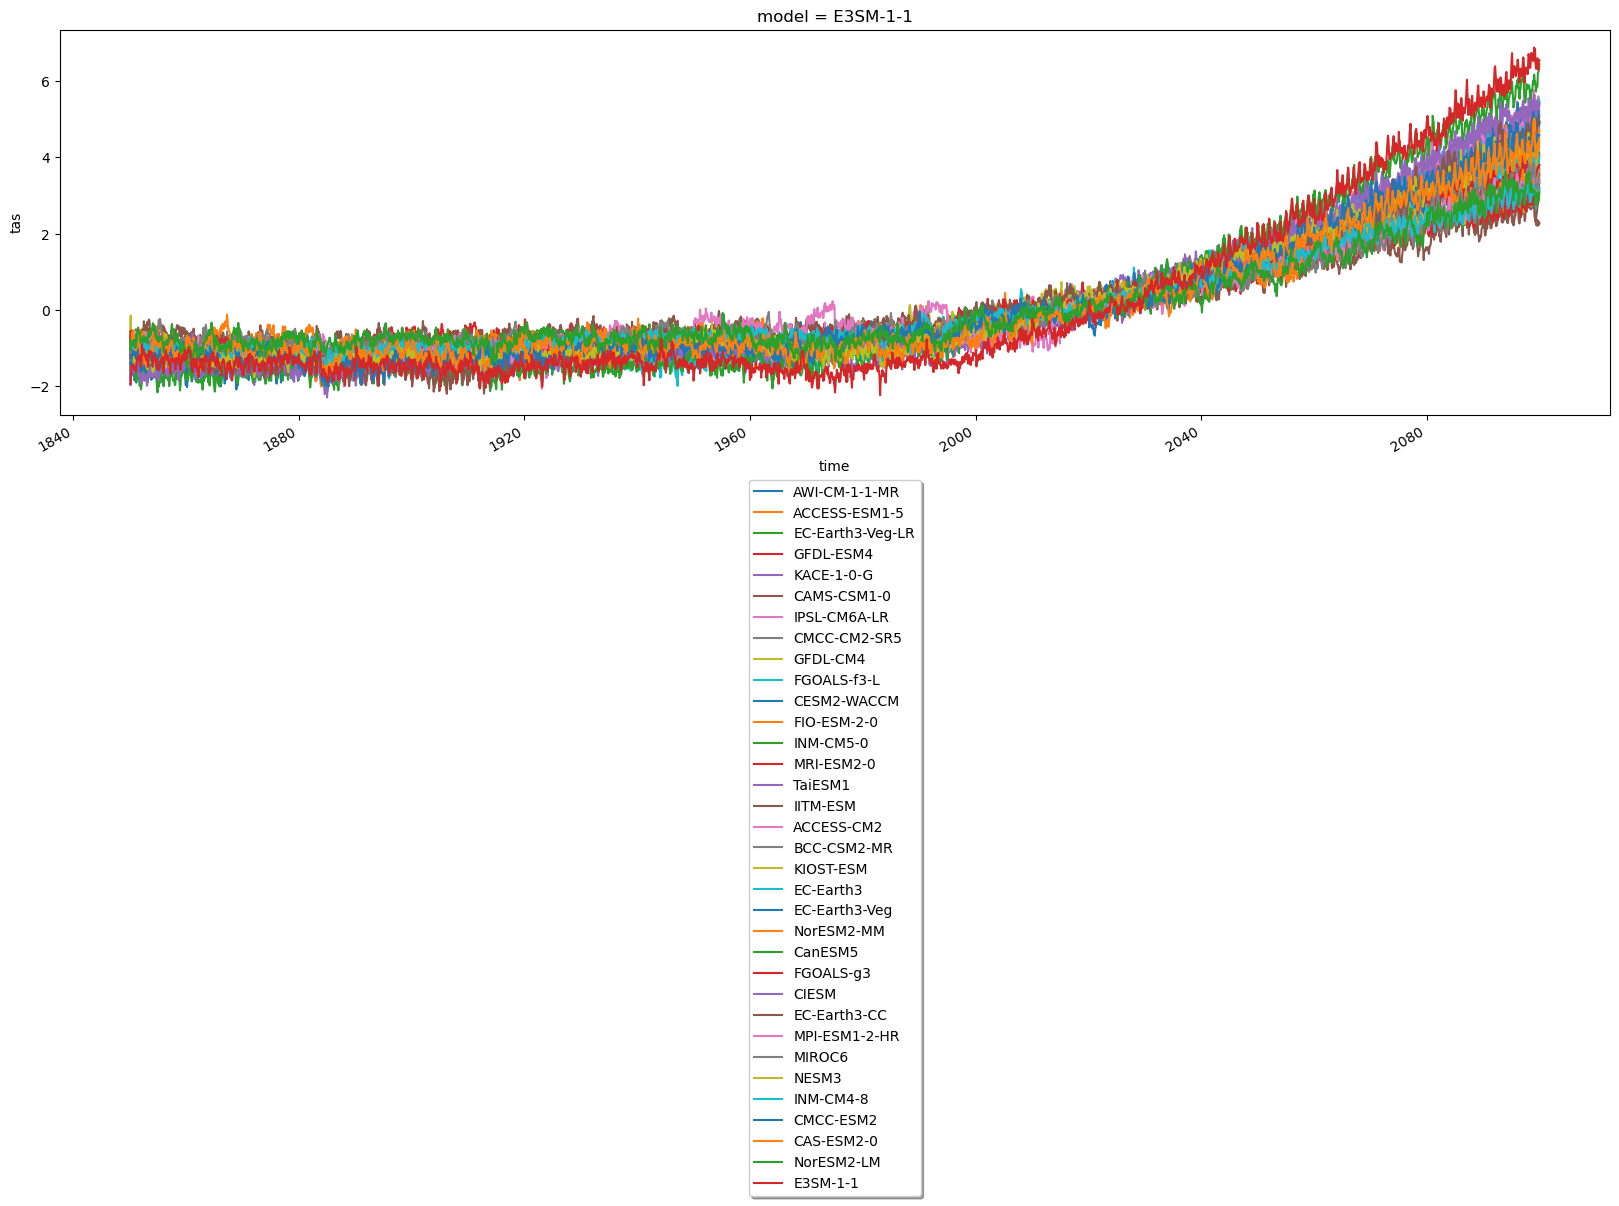

In [89]:
#redo figure with the model legend name on the bottom
fig, ax = plt.subplots(figsize=(20,5))
# Plot each line separately and collect the lines and labels
handles = []
labels = []
for m in ds_all_models_anom.model.values:
    line = ds_all_models_anom.sel(model=m).plot.line(ax=ax, x='time', hue='model', add_legend=False)
    handles.append(Line2D([], [], color=line[0].get_color(), label=m))  # Create Line2D handle
    labels.append(m)
ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

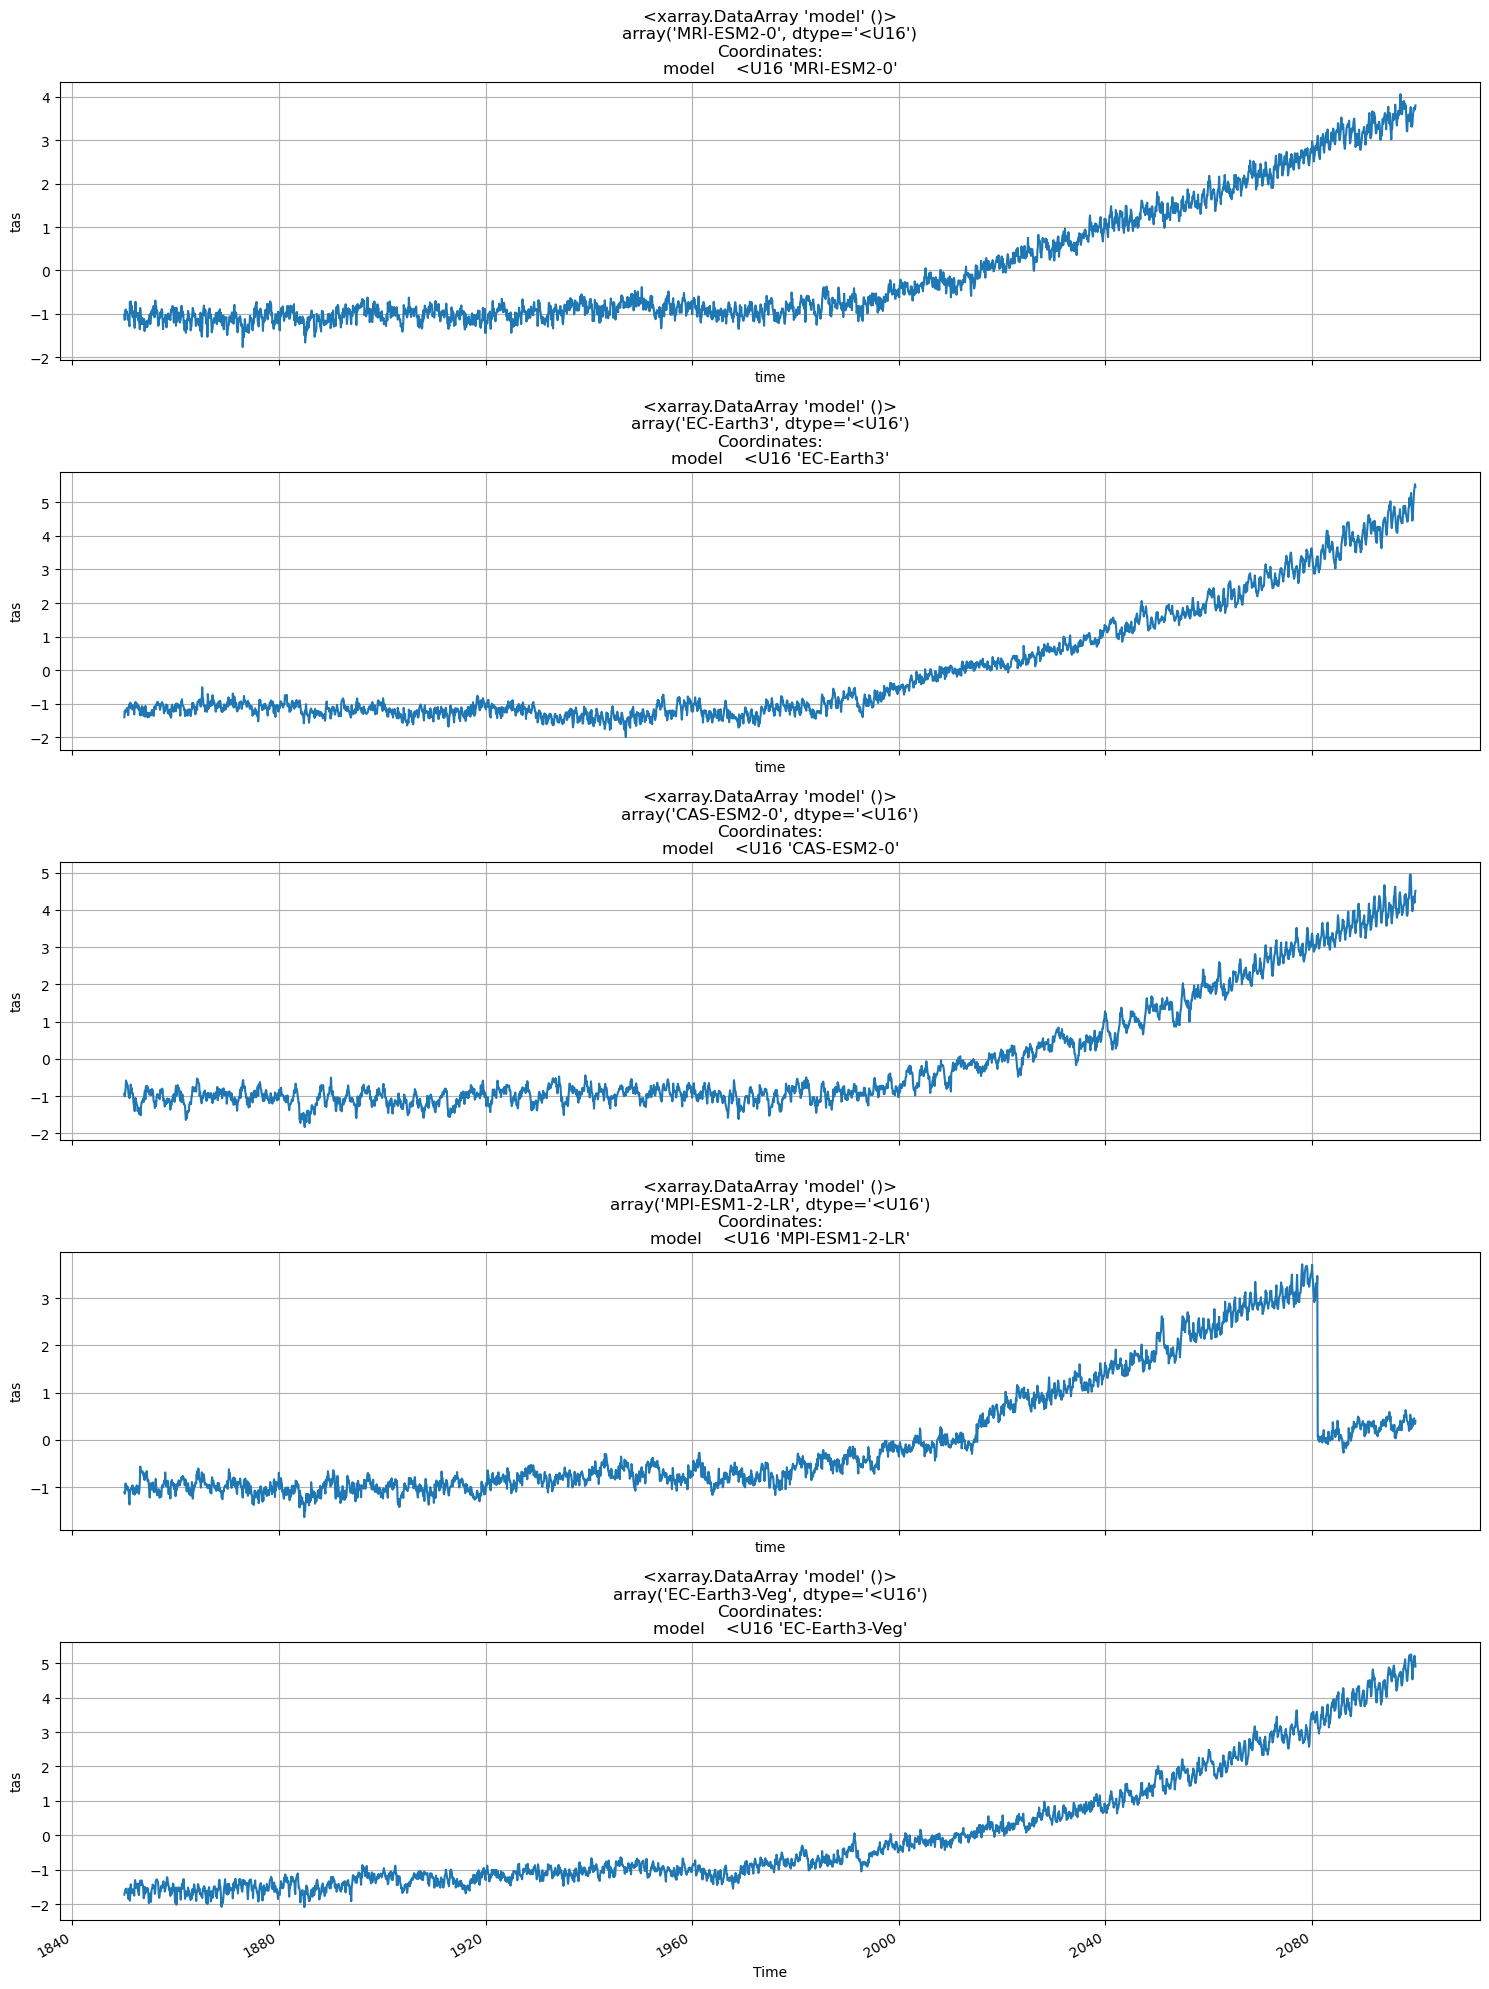

In [49]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter = 0
while fig_counter < (5): #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models_anom.model[20:]): #sliced from 30th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter >= (5):
            break
        ds_all_models_anom.sel(model=model).plot.line(ax=axs[i],label=model, x = 'time')
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

In [73]:
#general idea of what to do based on onlien sources
#identify start year (1850) and the start year where the actual model is initialized that you need to fill in
#iterate thru the model and identify which models need to be filled in (we can skip and just manually do this w only two
#for those models, create a mask that fill nan for the time rnage up to the model's start year
#update data
#gn fn = gen_fun(type_of_date_time, model) -> return dataset for model, get type of date time by doing type(ds.time)

In [80]:
#problem: we need to overwrite the historical model for it -> how do we do it in the for loop?
#do we create a conditional? we could do that like if source == 'XXXX model': df_hist = new_hist_w_nans

In [88]:
#saving to netcdf file
ds_all_models.to_netcdf("processed_tas_global_data.nc", mode = 'w', format = "NETCDF4", engine = 'netcdf4')